# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [3]:
FILENAME_DATASET = '/content/drive/MyDrive/10 - UB /30 - 2nd semester courses/60 - Data Science Ethics/Recidivism Assignment/reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [4]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [5]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

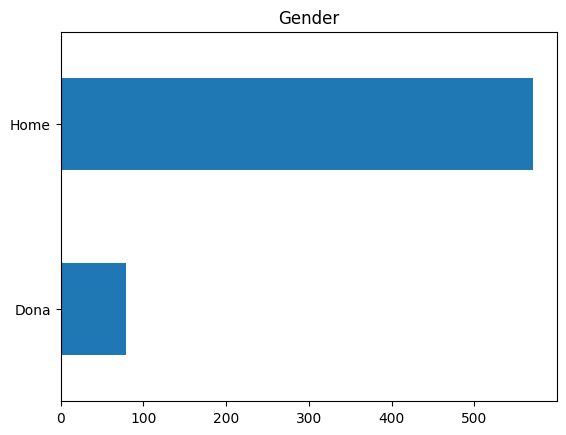

In [6]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

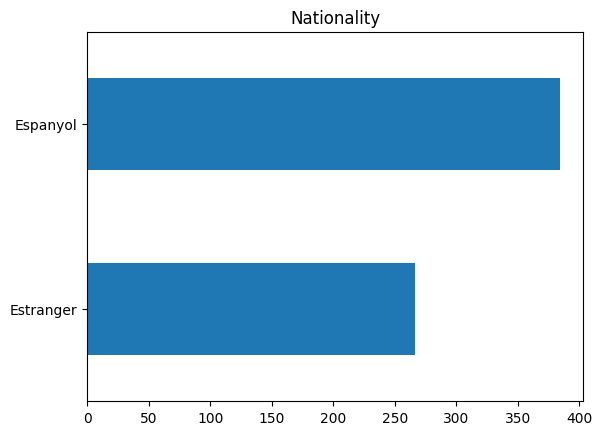

In [7]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

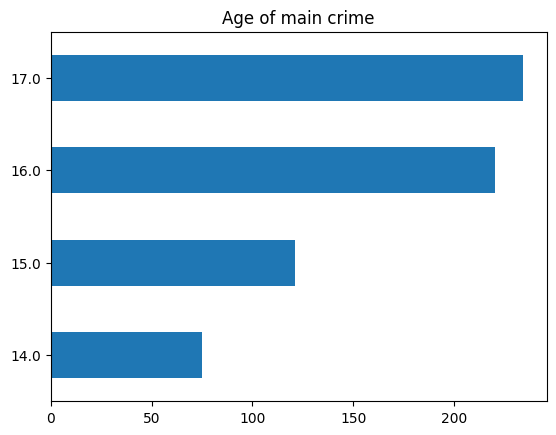

In [8]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

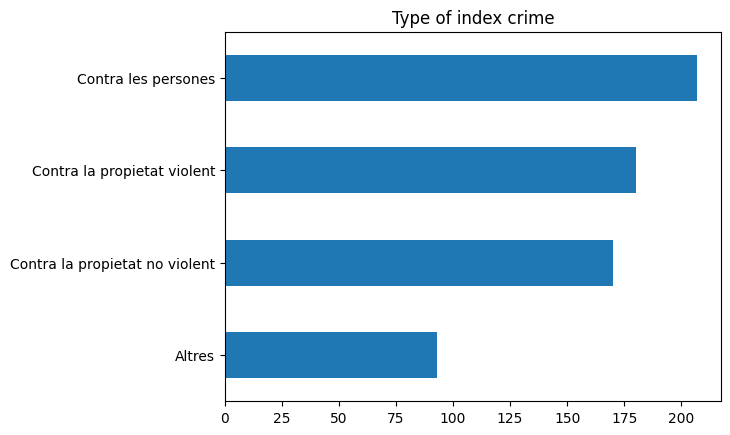

In [9]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

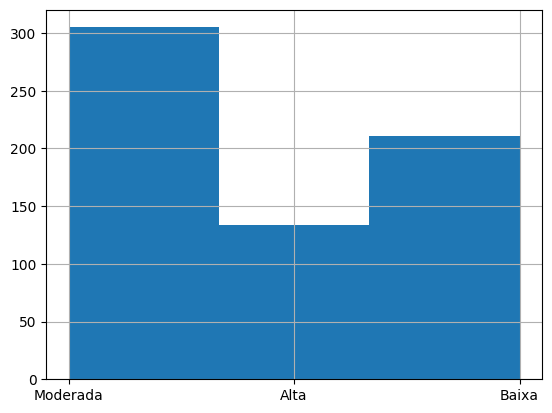

In [10]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

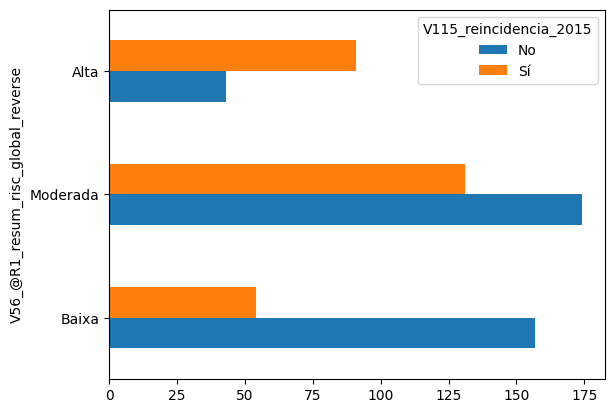

In [11]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [12]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [13]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [14]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

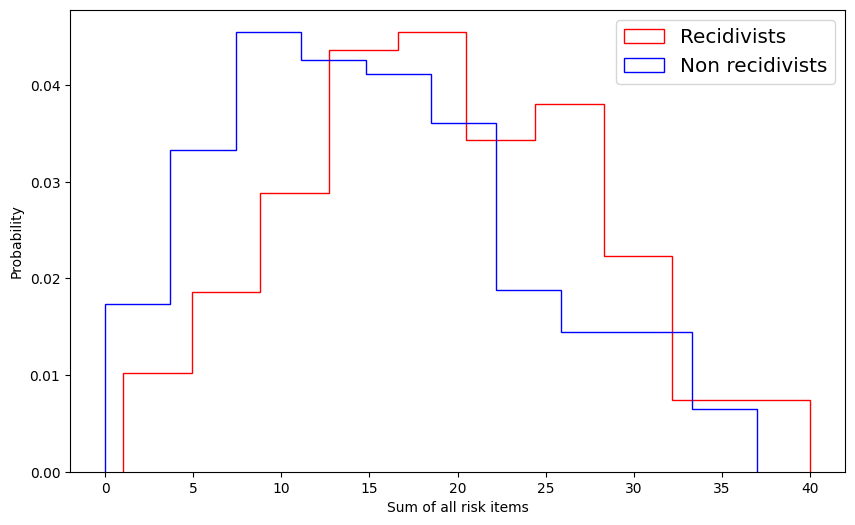

In [15]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [16]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

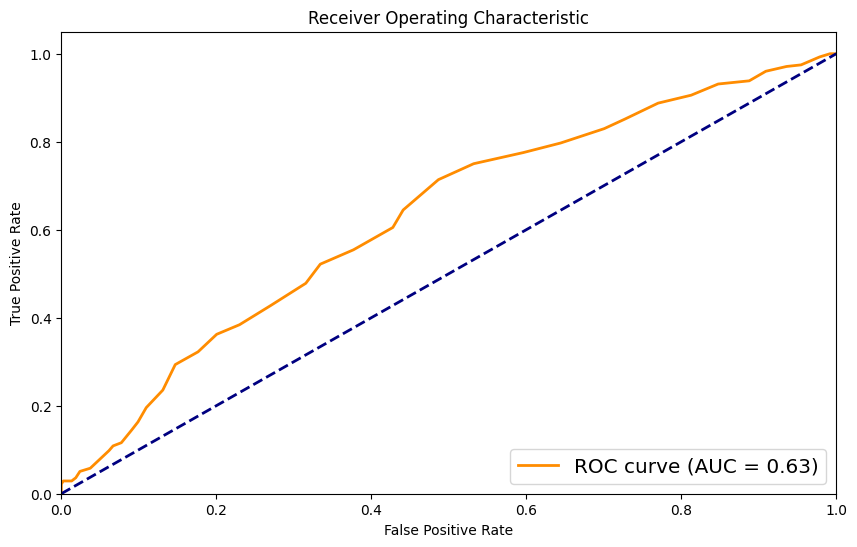

In [17]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [18]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [19]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [20]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [21]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

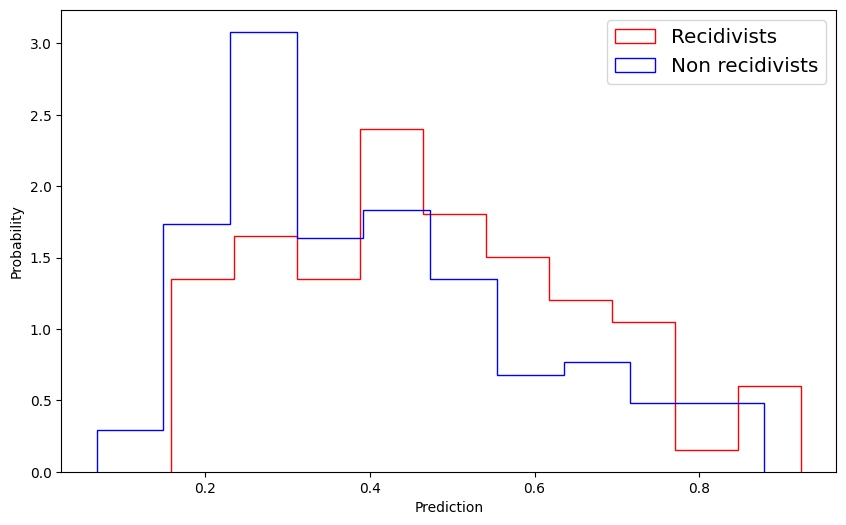

In [22]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

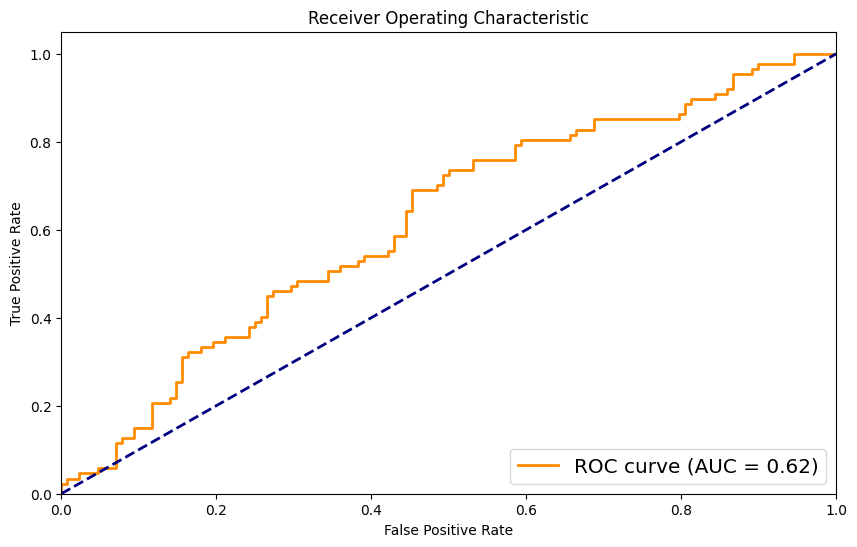

In [23]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [24]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [25]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [26]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

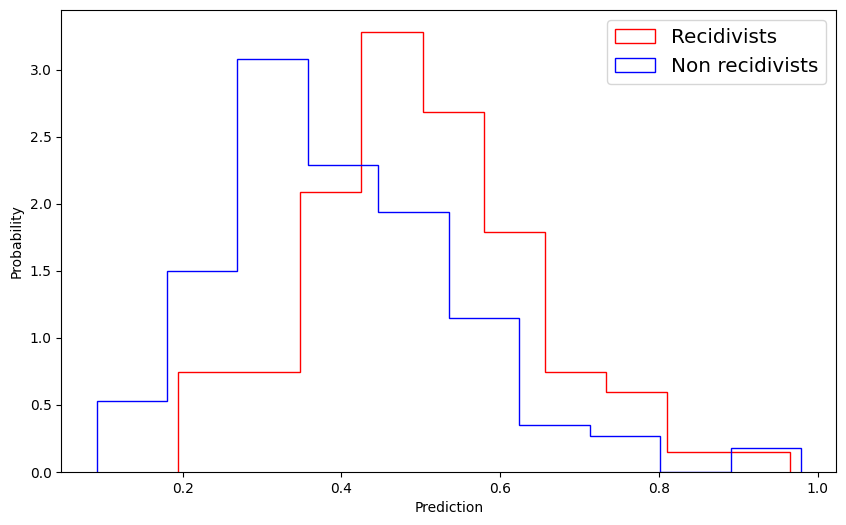

In [27]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

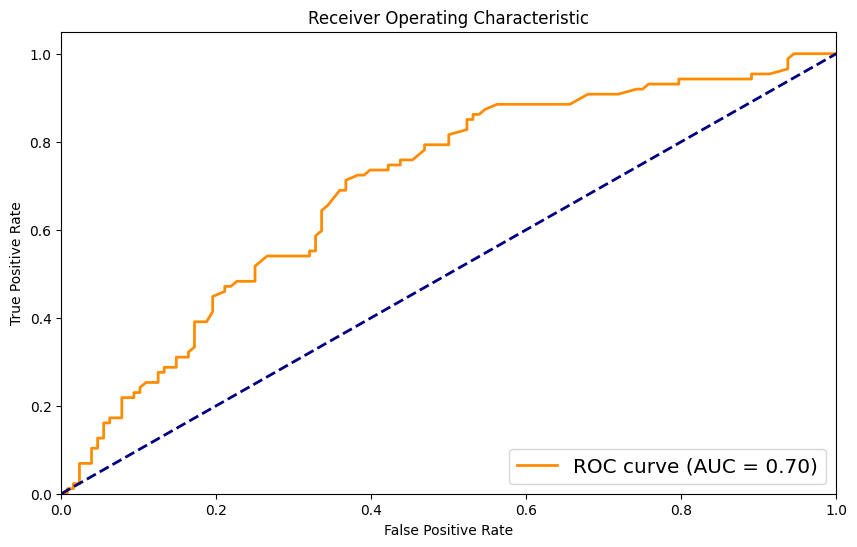

In [28]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [29]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [30]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [31]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

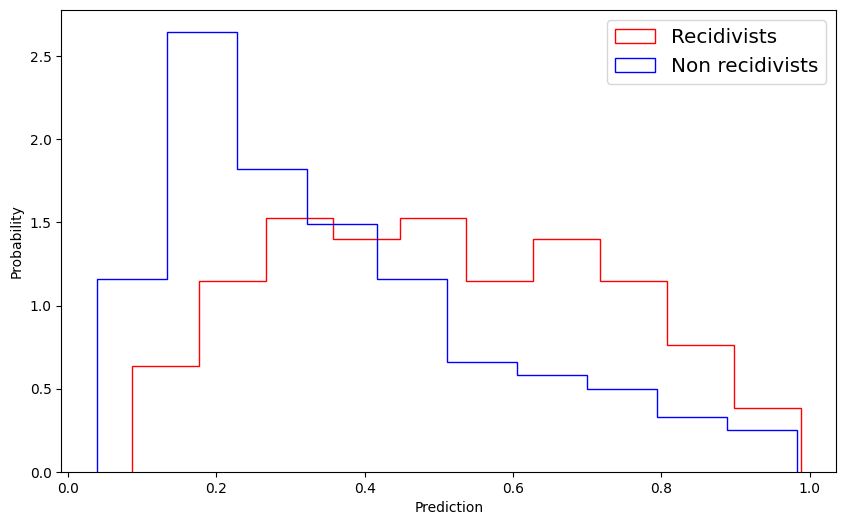

In [32]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

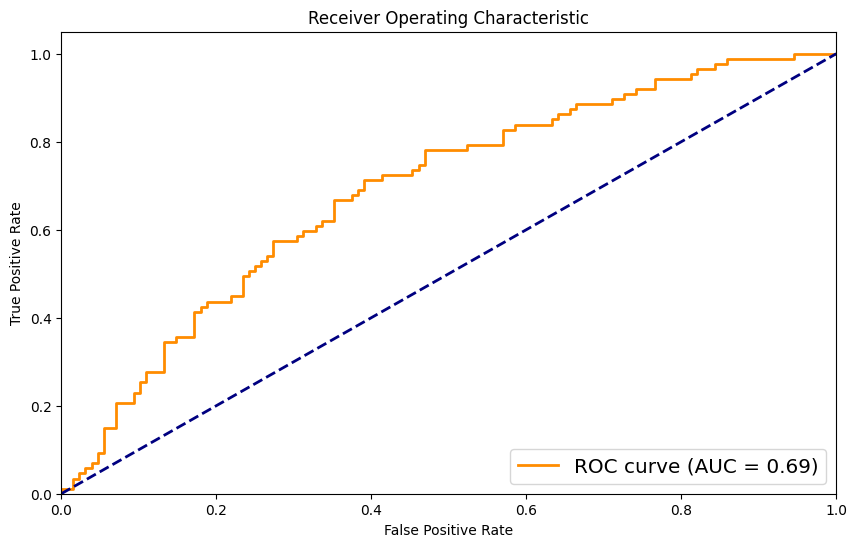

In [33]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [34]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [35]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [36]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [37]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [38]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 19.12
Average SAVRY score of women non-recidivist: 15.67


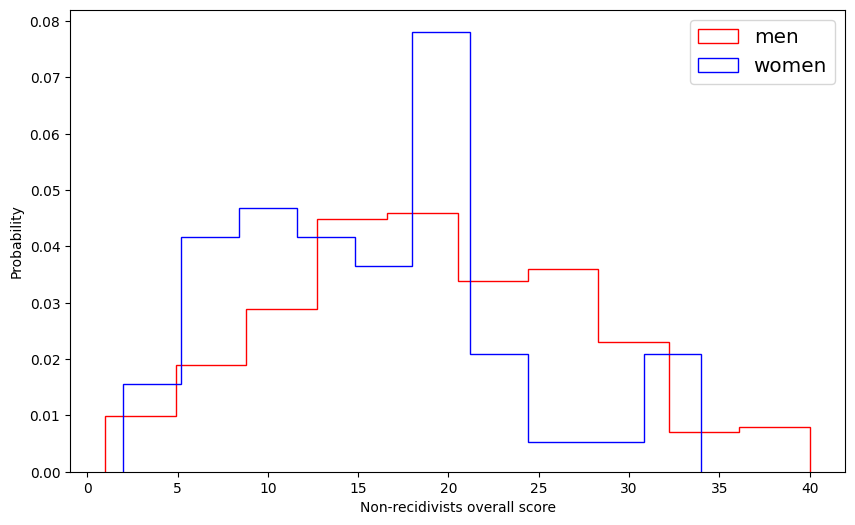

In [39]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [40]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


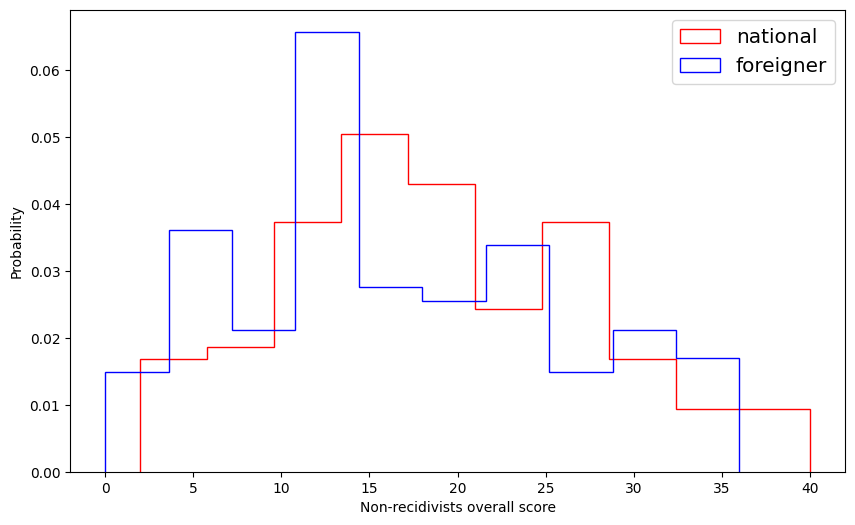

In [41]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [42]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.42
Average predicted probability of women non-recidivist: 0.26


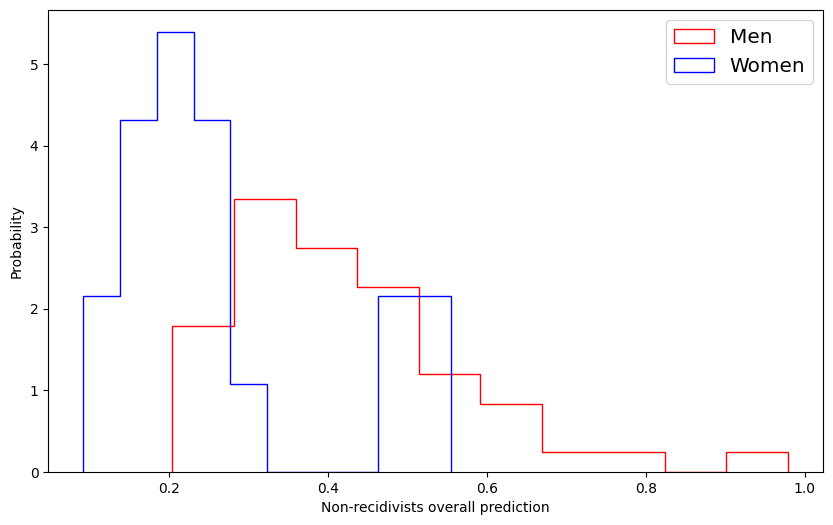

In [43]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [44]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.36
Average predicted probability of foreigner non-recidivist: 0.48


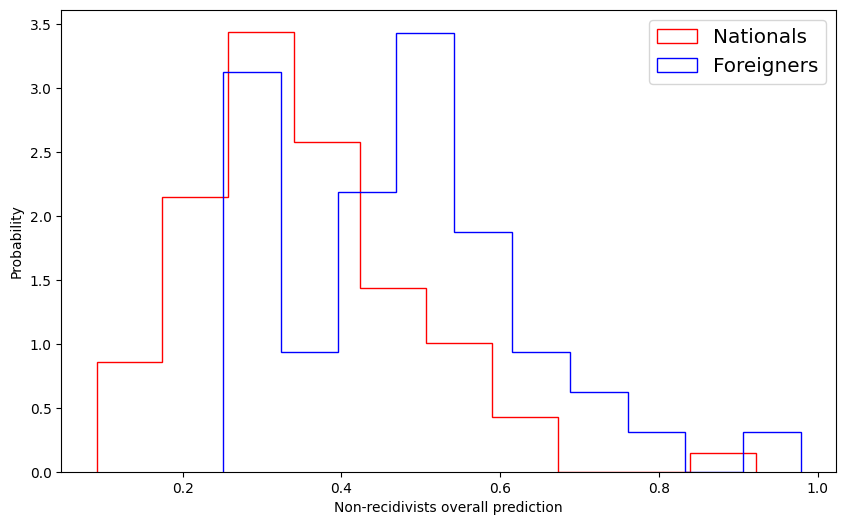

In [45]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



Let's start by recalling what are the benchmark results, in terms of performance and fairness, the **professional human expert score**, and the **SAVRY score** 

In [46]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
Bias_sex = abs(non_recidivists_expert_by_gender["Home"] - non_recidivists_expert_by_gender["Dona"])

non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
Bias_nationality = abs(non_recidivists_expert_by_nationality["Espanyol"] - non_recidivists_expert_by_nationality["Estranger"])

d = {'Sex Bias': Bias_sex, 'Nationality Bias': Bias_nationality}
df_bias_expert = pd.DataFrame(data=d)
df_bias_expert

,Sex Bias,Nationality Bias
V56_@R1_resum_risc_global_reverse,,
Alta,0.002017,0.022775
Baixa,0.016136,0.011655
Moderada,0.018153,0.011121


Taking the averages over the three classes

In [47]:
d = {'Sex Bias': [Bias_sex.mean()], 'Nationality Bias': [Bias_nationality.mean()], 'Total Bias': [Bias_sex.mean()+Bias_nationality.mean()]}
df_bias_expert = pd.DataFrame(data=d)
df_bias_expert

,Sex Bias,Nationality Bias,Total Bias
0,0.012102,0.015183,0.027285


We can already expect the results to be highly dependent from the train/test split, considering the size of the dataset and the 0.3 split, and thus to vary considerably. The correct approach to this would be to analyse the results making use of cross-validation. In this case, since the computation time is not very high and it is not the primary focus of the exercise, the cross-validation that will be implemented is not extremely comprehensive and the code is not optimized to reduce computation. However, it should be a simple implementation that would grant considerably more consistent and more solid results. (The metrics analyzed will be the results of averaging over the different instances of the cross-validation routine)

For this purpose we slightly change some previously defined functions

In [48]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí", output=True):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    if output==True:
        plt.figure(figsize=(10,6))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right", fontsize='x-large')
        plt.show()
    return roc_auc

## 1.1 Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model.

Let's begin by defining the models we will be checking in terms of performance and fairness

In [49]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [50]:
# Initialize the models
logistic = LogisticRegression(solver='liblinear')
ada_boost = AdaBoostClassifier()
gradient_boost = GradientBoostingClassifier()
random_forest = RandomForestClassifier()
bagging = BaggingClassifier()
extra_tree = ExtraTreeClassifier()
sgd = SGDClassifier(loss='log_loss')
naive_bayes = GaussianNB()
linear_discrimination = LinearDiscriminantAnalysis()
quadratic_discrimination = QuadraticDiscriminantAnalysis()
k_neighbors = KNeighborsClassifier()
mlp = MLPClassifier()
svm = SVC(probability=True)
lgbm = LGBMClassifier()
decision_tree = DecisionTreeClassifier()

models = [logistic, ada_boost, gradient_boost, random_forest, bagging, extra_tree, sgd, naive_bayes, linear_discrimination, quadratic_discrimination, k_neighbors, mlp, svm, lgbm, decision_tree]

In order to compare the performance of different machine learning models we consider the (24 risk factors + demographic factors + 6 protective factors) dataset

In [51]:
factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

We evaluate their performance by taking a look at the comparison of the histograms and the resulting ROC curve

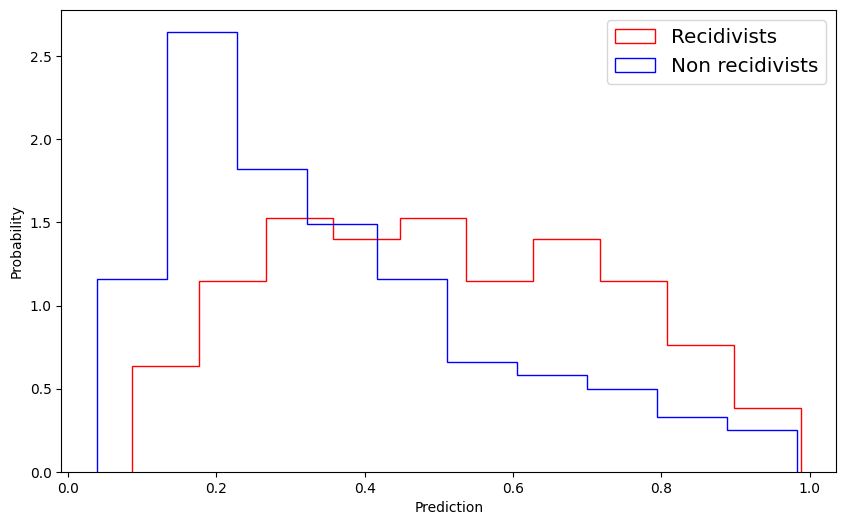

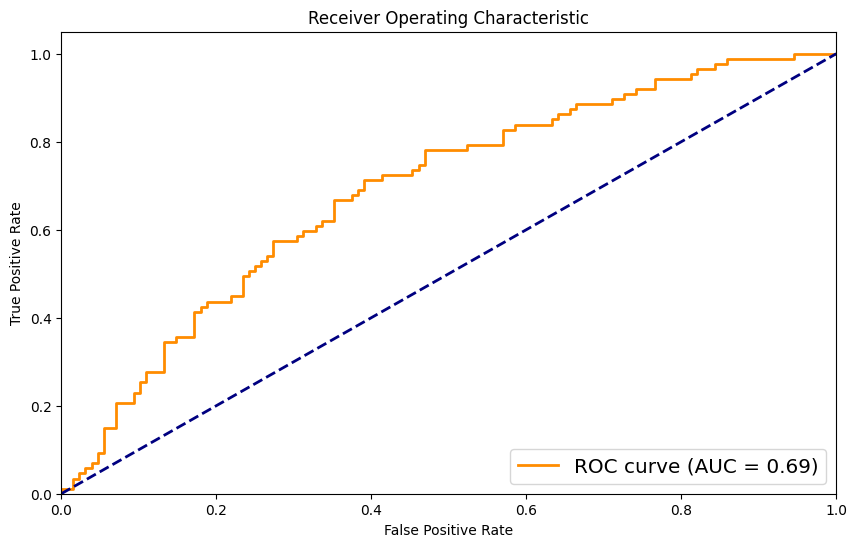

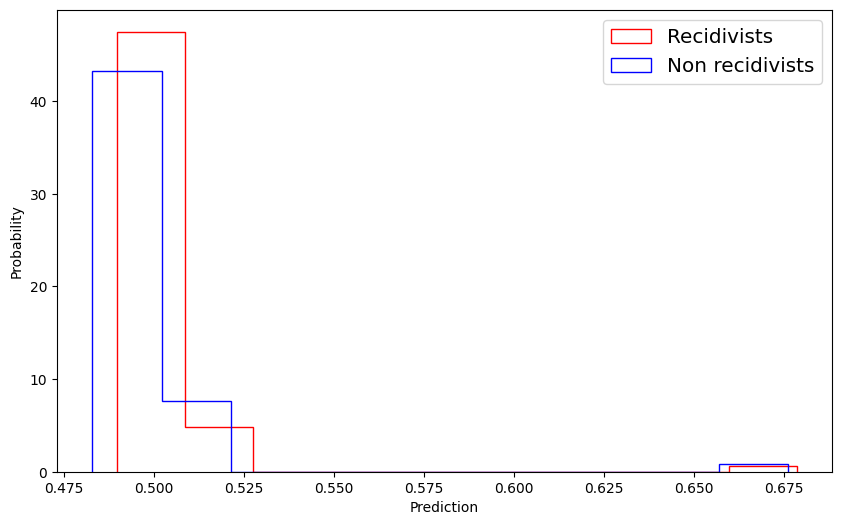

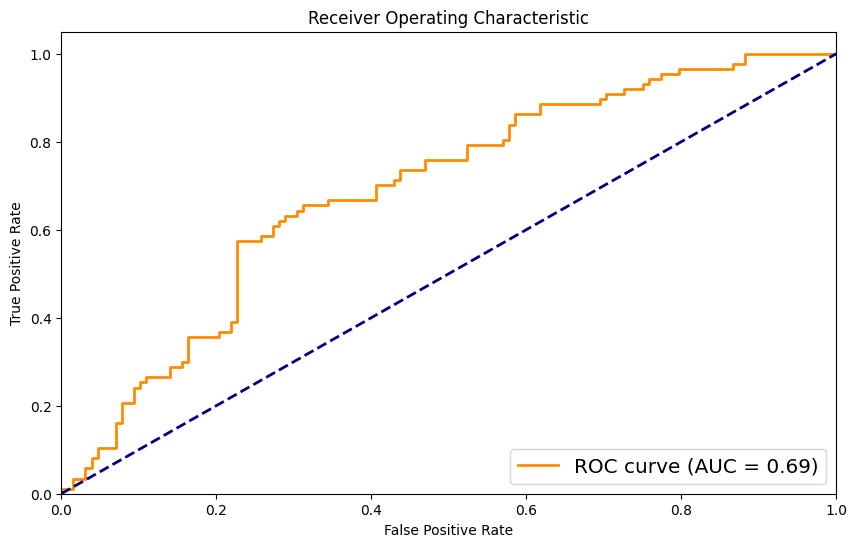

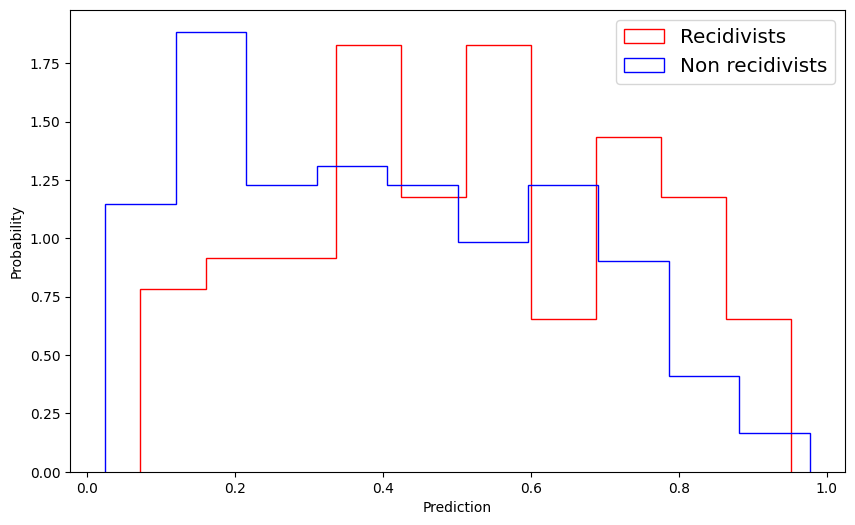

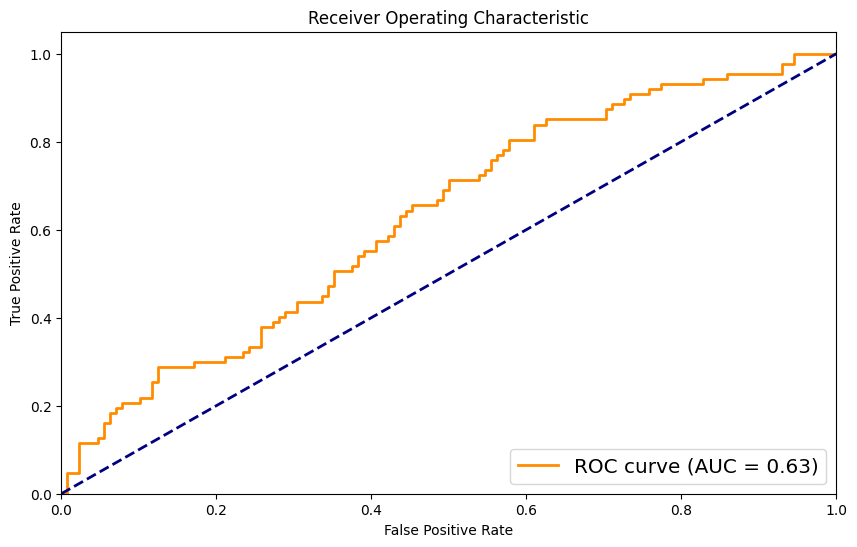

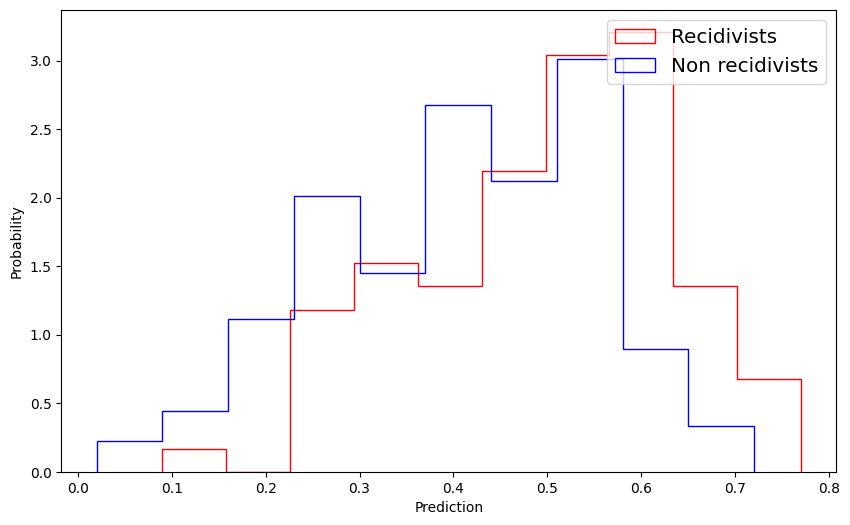

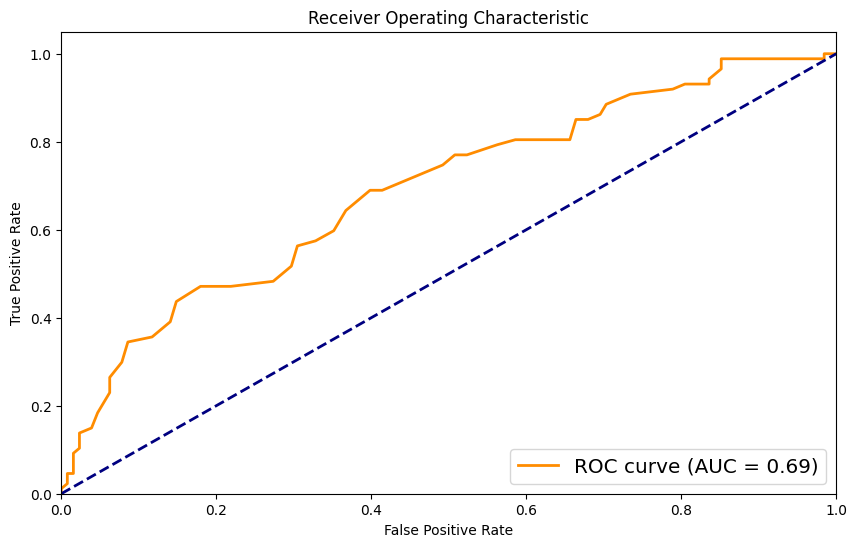

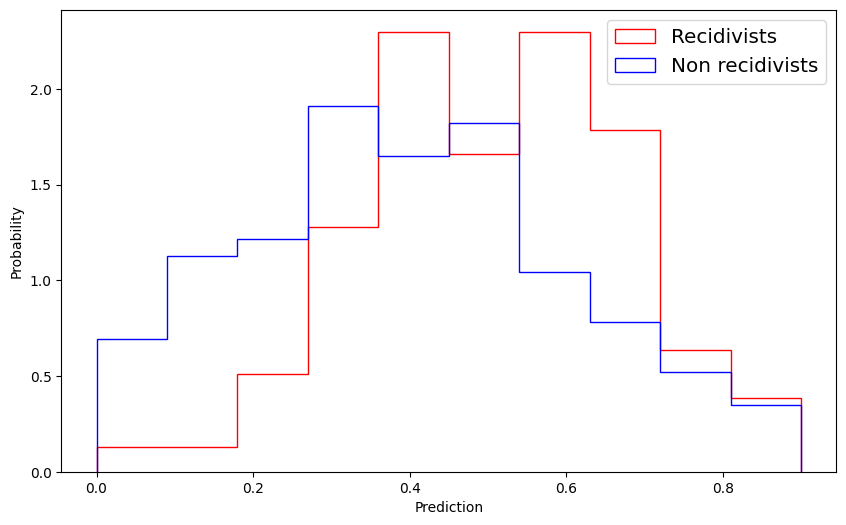

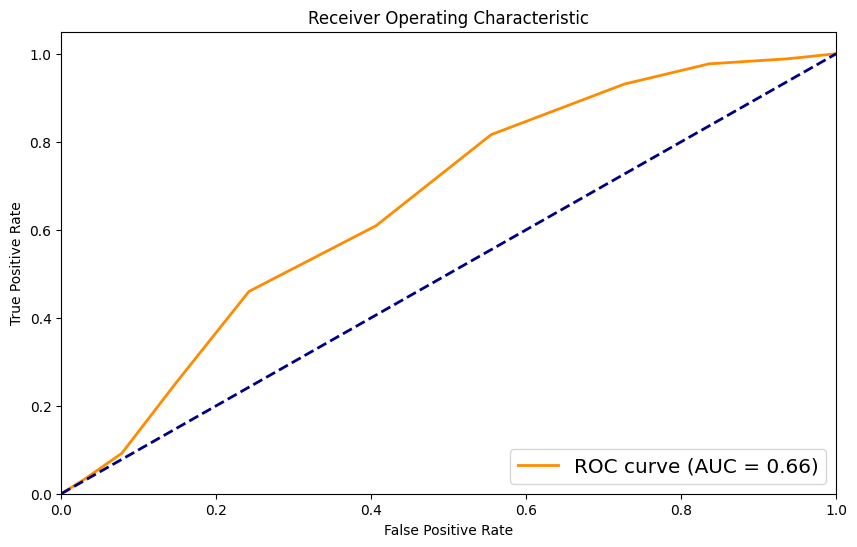

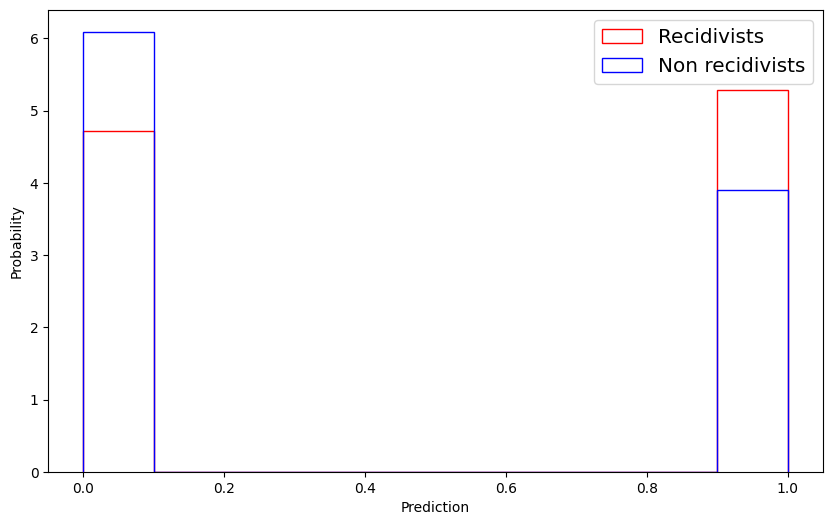

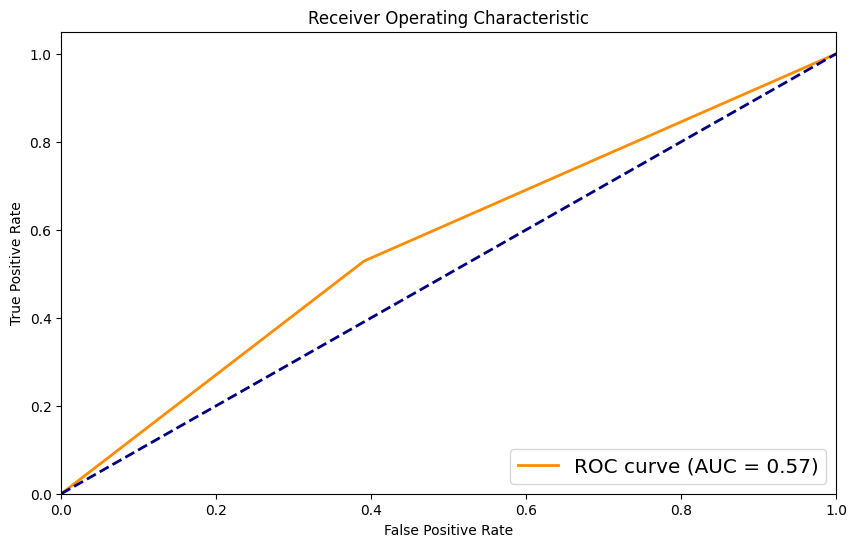

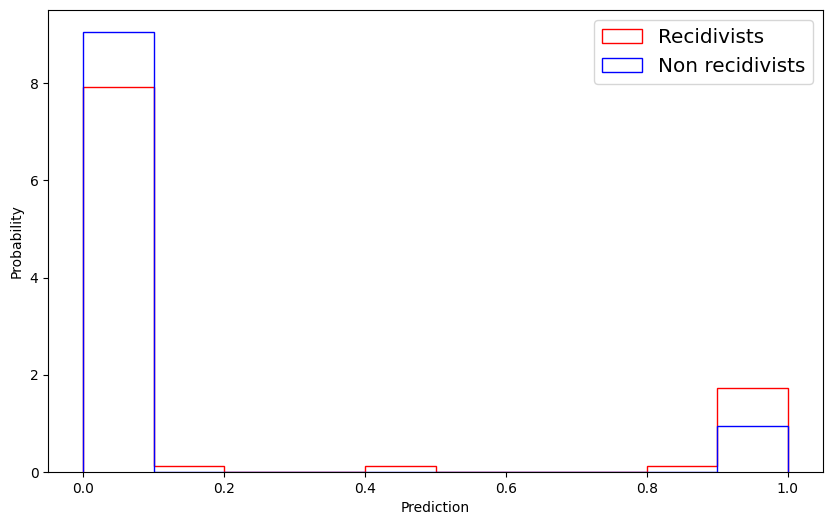

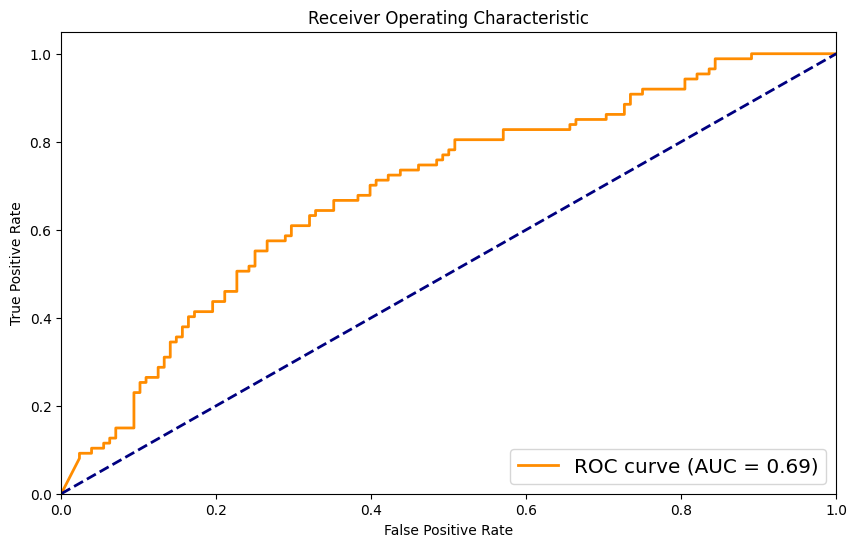

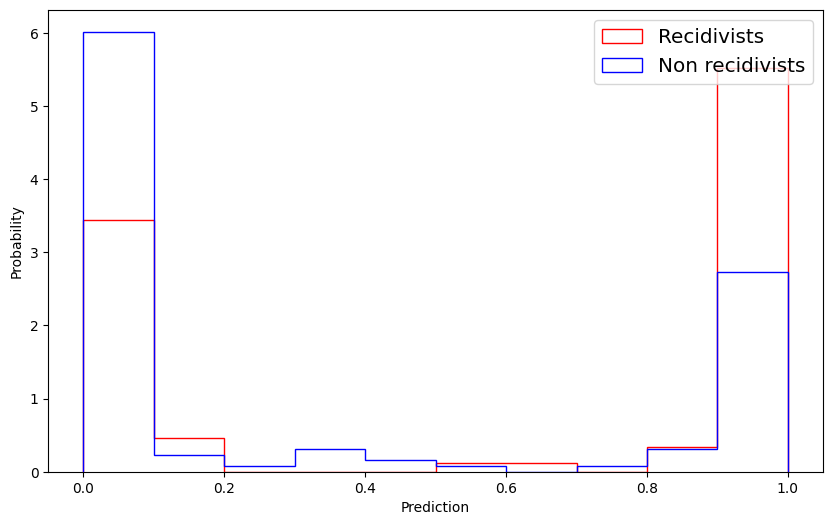

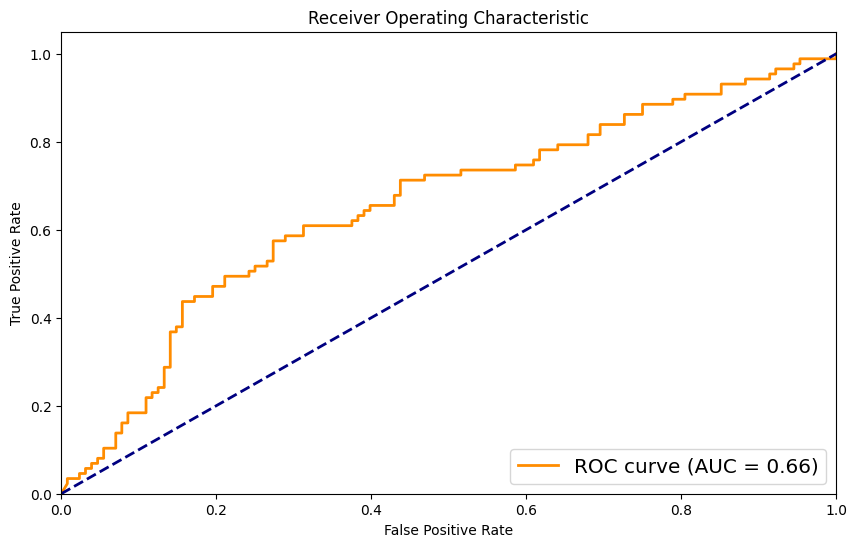

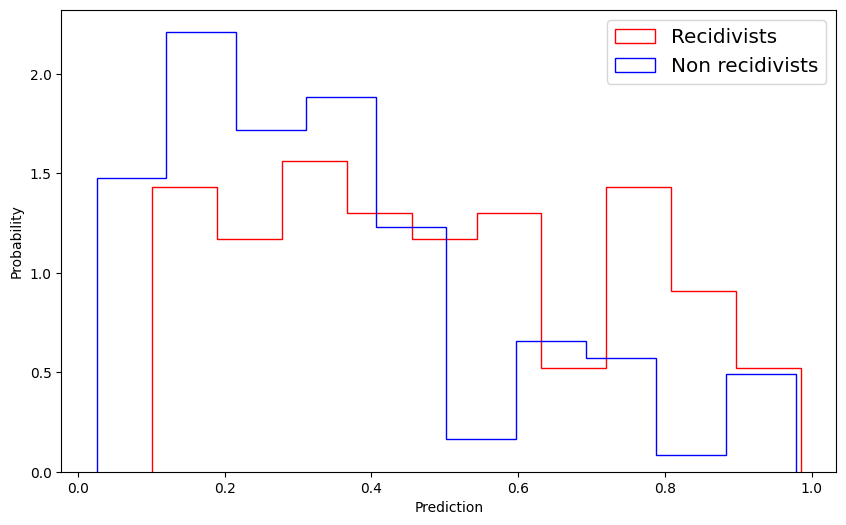

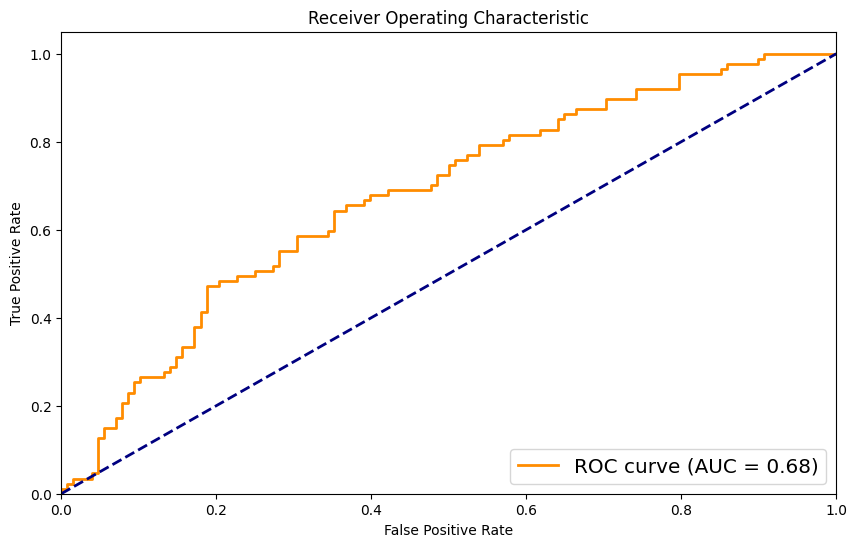

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


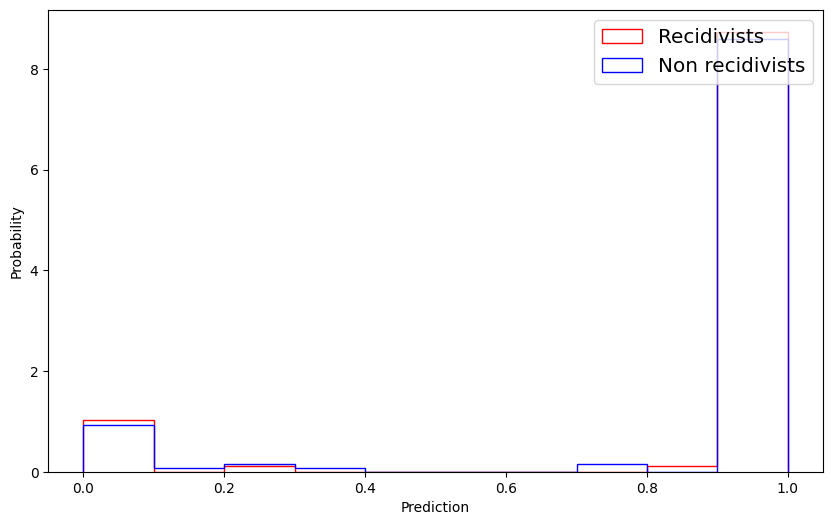

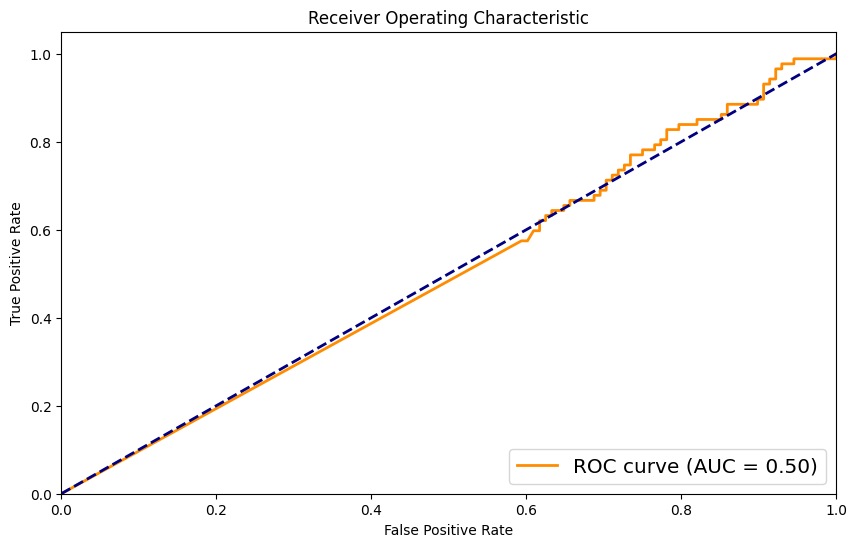

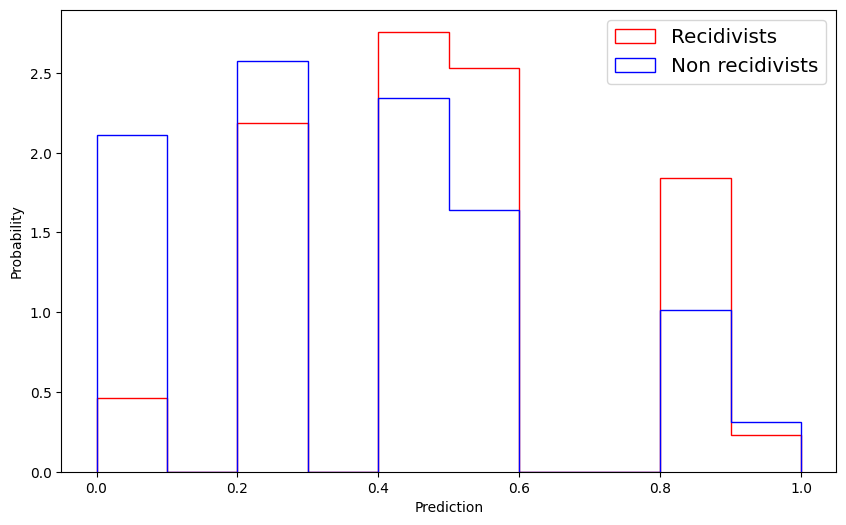

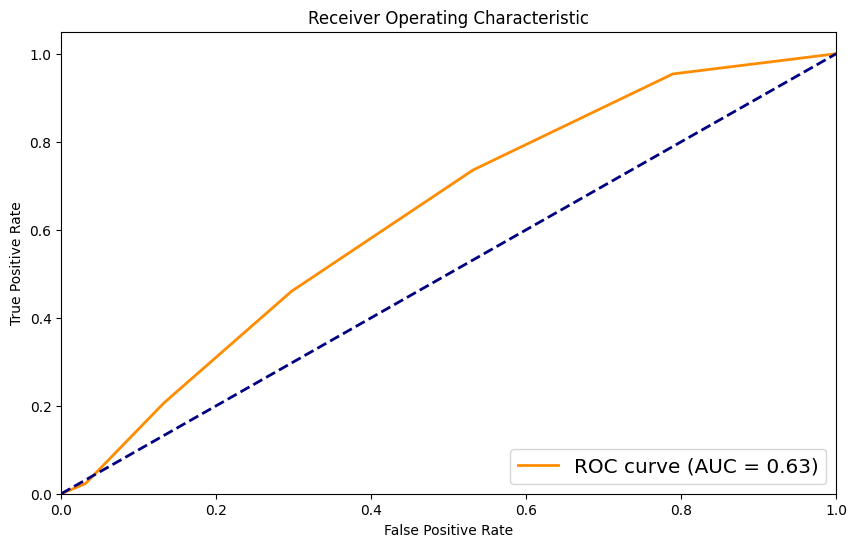

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


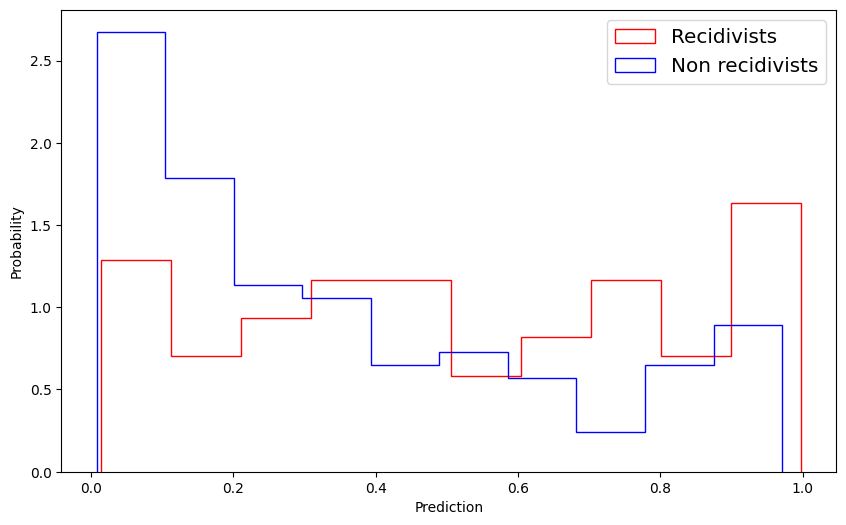

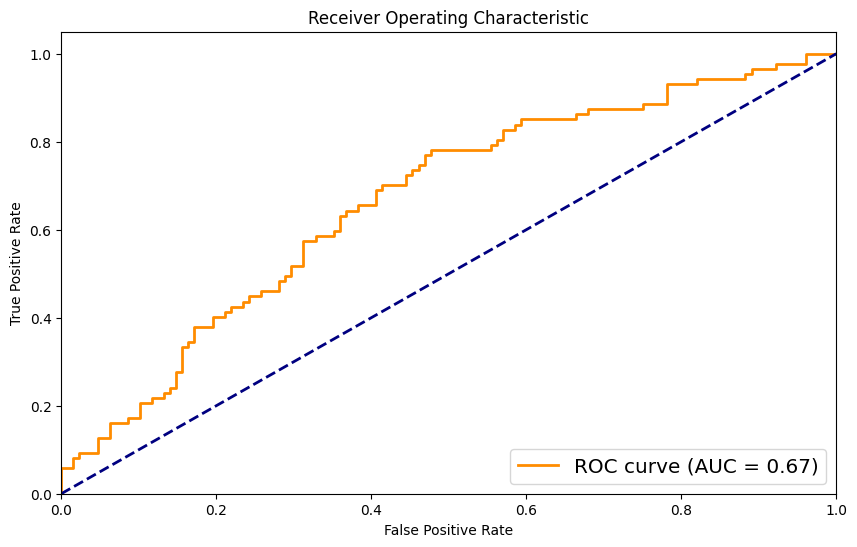

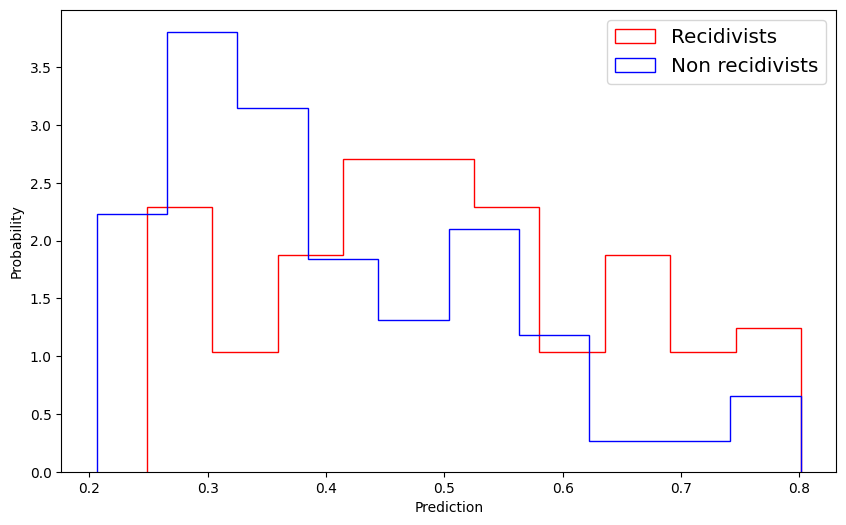

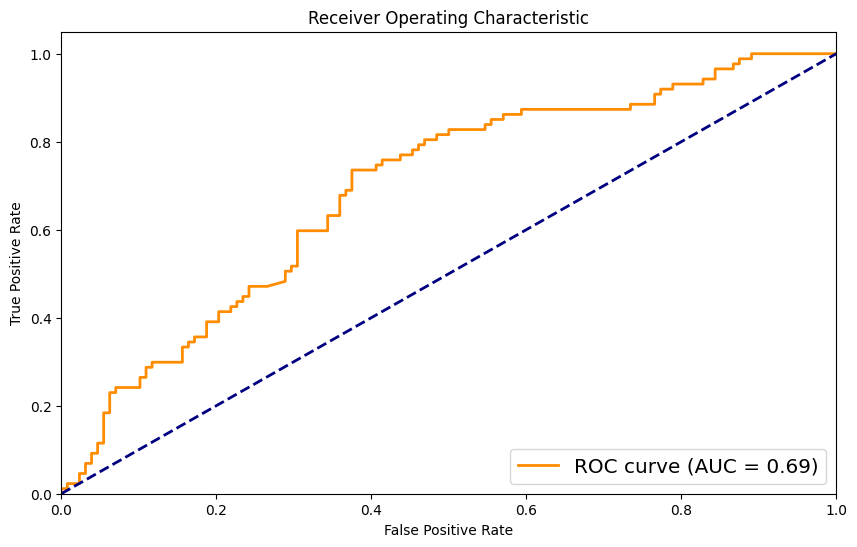

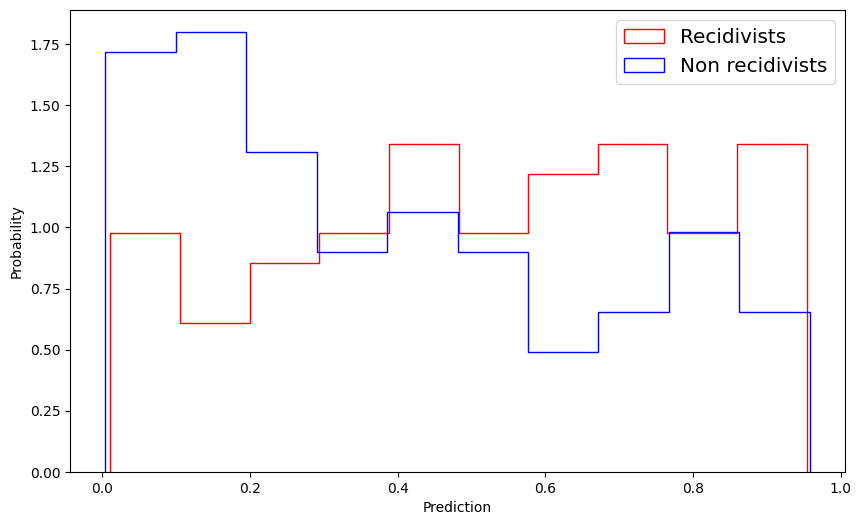

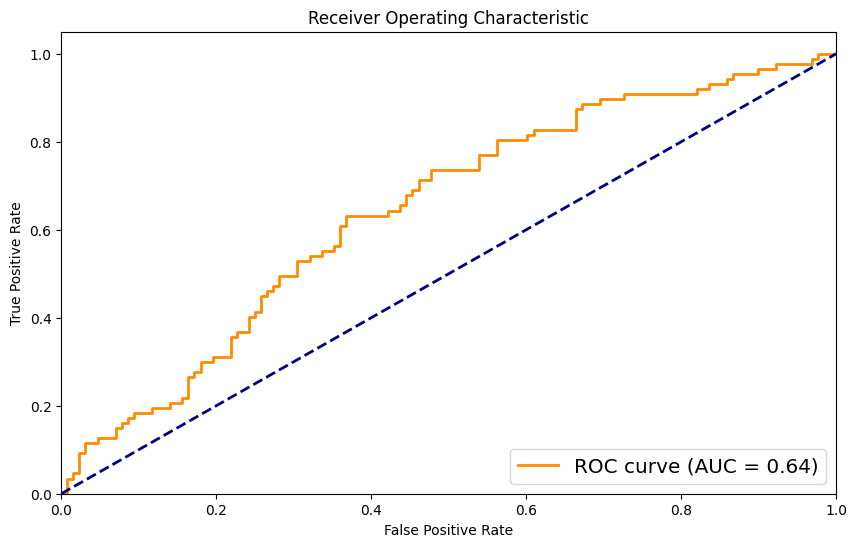

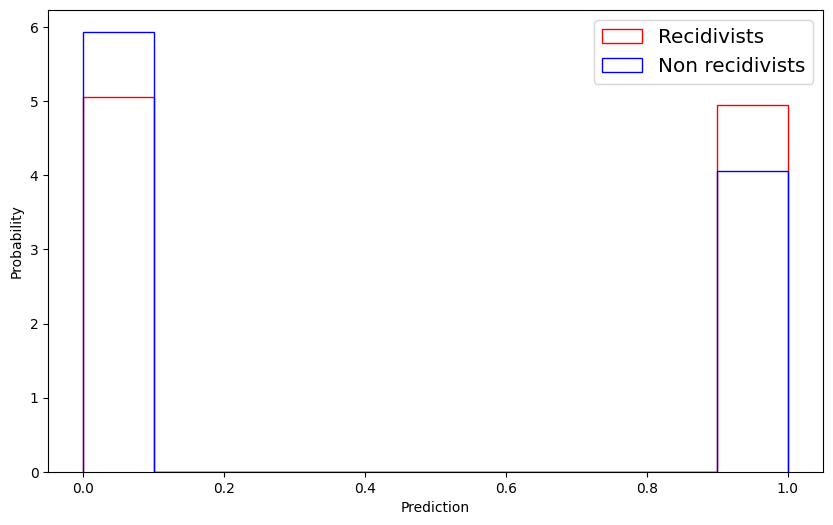

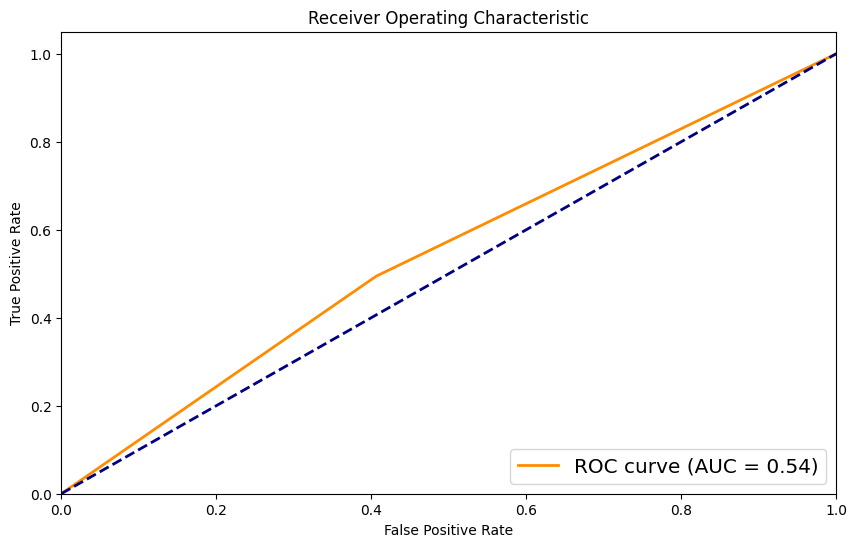

In [52]:
models_names = []
roc_aucs = []

# Train and evaluate each model
for model in models:
    models_names.append(type(model).__name__)
    # Train the model
    model.fit(train_X, train_y)
    # Evaluate the model
    predALL_y = model.predict_proba(test_X)[:,1]
    predALL_recidivists = predALL_y[test_y == 'Sí']
    predALL_non_recidivists = predALL_y[test_y == 'No']
    compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')
    roc_auc = draw_roc_curve(test_y, predALL_y)
    roc_aucs.append(roc_auc)

In [53]:
d = {'model': models_names, 'ROC_AUC': roc_aucs}
df_roc = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_roc.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC
0,LogisticRegression,0.689835
1,AdaBoostClassifier,0.691272
2,GradientBoostingClassifier,0.629221
3,RandomForestClassifier,0.690059
4,BaggingClassifier,0.658944
5,ExtraTreeClassifier,0.569055
6,SGDClassifier,0.687994
7,GaussianNB,0.655621
8,LinearDiscriminantAnalysis,0.676634
9,QuadraticDiscriminantAnalysis,0.499371


As previously mentioned, these results are not very solid and strongy depend on  the train/test split. We thus now implement a cross-validation routine to return some more consistent results

In [54]:
cross_validation_instances = 10
ROC_AUC = np.zeros([len(models_names), cross_validation_instances])

for i in range(cross_validation_instances): 
    train, test = train_test_split(df, test_size=0.33)

    train_X = pd.get_dummies(train[factors])
    train_y = train["V115_reincidencia_2015"]

    test_X = pd.get_dummies(test[factors])
    test_y = test["V115_reincidencia_2015"]

    # Train and evaluate each model
    for j in range(len(models)):
        # Train the model
        models[j].fit(train_X, train_y)
        # Evaluate the model
        predALL_y = models[j].predict_proba(test_X)[:,1]
        predALL_recidivists = predALL_y[test_y == 'Sí']
        predALL_non_recidivists = predALL_y[test_y == 'No']
        roc_auc = draw_roc_curve(test_y, predALL_y, output=False)
        ROC_AUC[j,i] = roc_auc

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_mult

In [55]:
roc_aucs = np.mean(ROC_AUC, axis=1)

d = {'model': models_names, 'ROC_AUC': roc_aucs}
df_roc = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_roc.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC
0,LogisticRegression,0.645637
1,AdaBoostClassifier,0.643761
2,GradientBoostingClassifier,0.636783
3,RandomForestClassifier,0.649559
4,BaggingClassifier,0.609206
5,ExtraTreeClassifier,0.542177
6,SGDClassifier,0.618623
7,GaussianNB,0.665195
8,LinearDiscriminantAnalysis,0.641770
9,QuadraticDiscriminantAnalysis,0.607431


The best performing model seems to be, consistently, the SVM

## 1.2 Check if they satisfy the proposed fairness criteria. 

We now check the proposed fairness criteria. Notice that from here on when discussing the implemented fairness criteria we take into consideration the binary classification case. However, for regression models that output a score, bounded within 0 and 1, the definition can be extended by averaging the scores, seeing them as probabilities, and obtaining the probability over a group. </br> 
The proposed fairness criteria compare the probability of receiving a predicted positive labelling given that the true label is negative and the samples belong to each protected group, meaning

$$\mathbb{P}(\hat{Y}=1|Y=0, X\in G^+) = \mathbb{P}(\hat{Y}=1|Y=0, X\in G^-)$$

Therefore, it consider equal False Positive rates over different protected groups

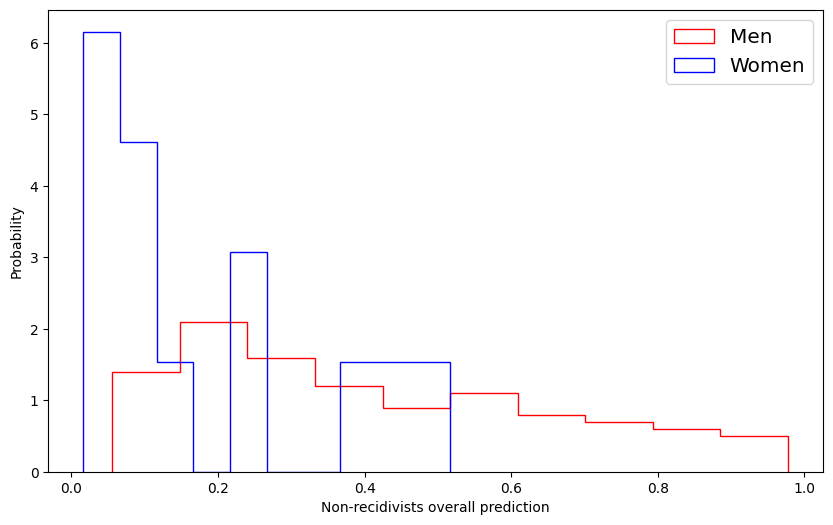

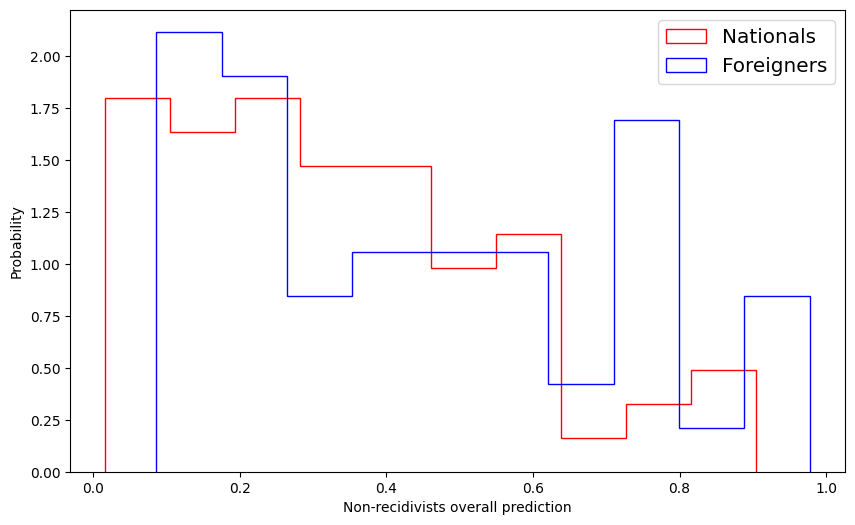

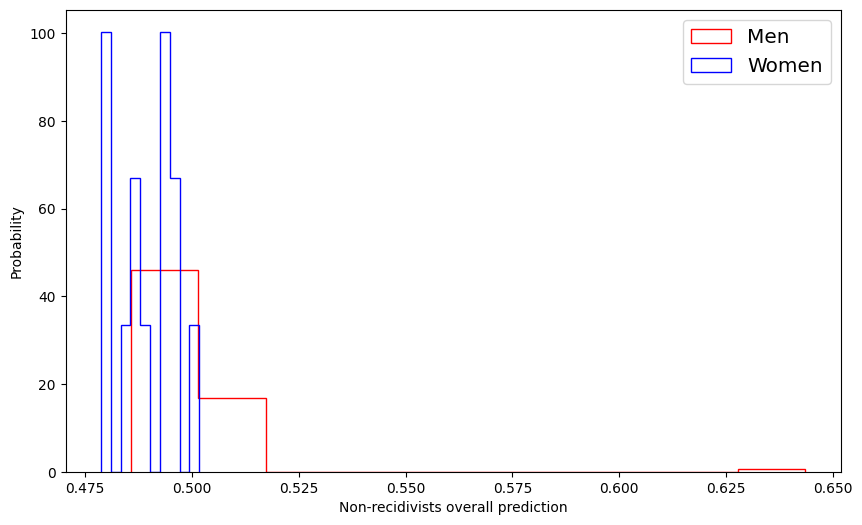

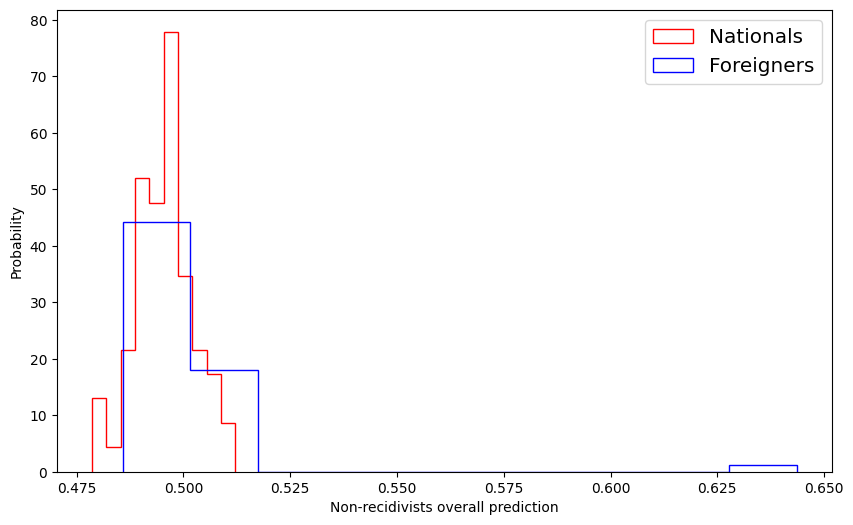

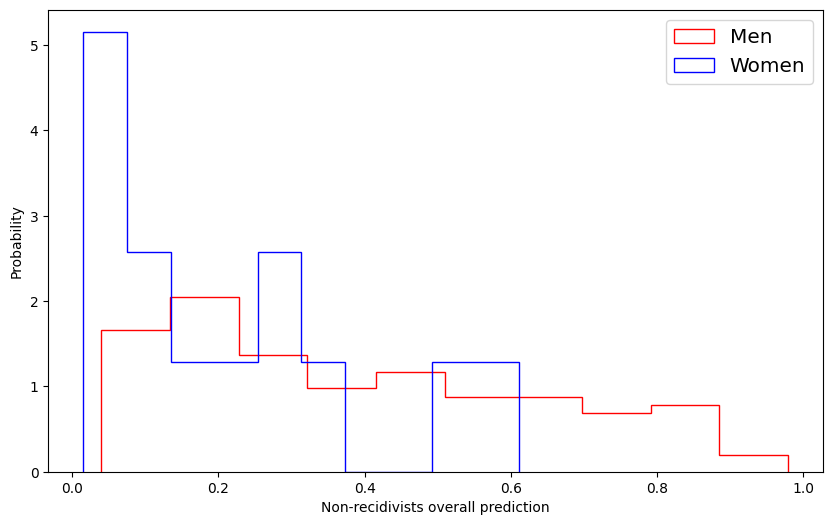

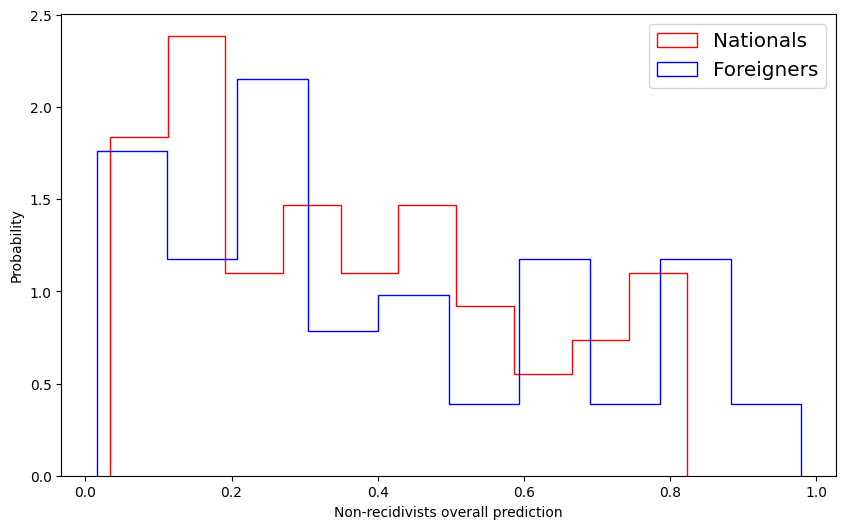

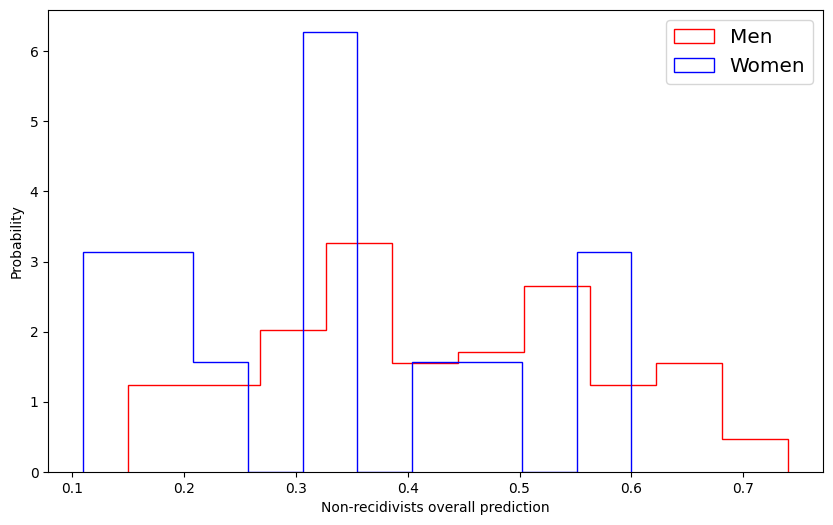

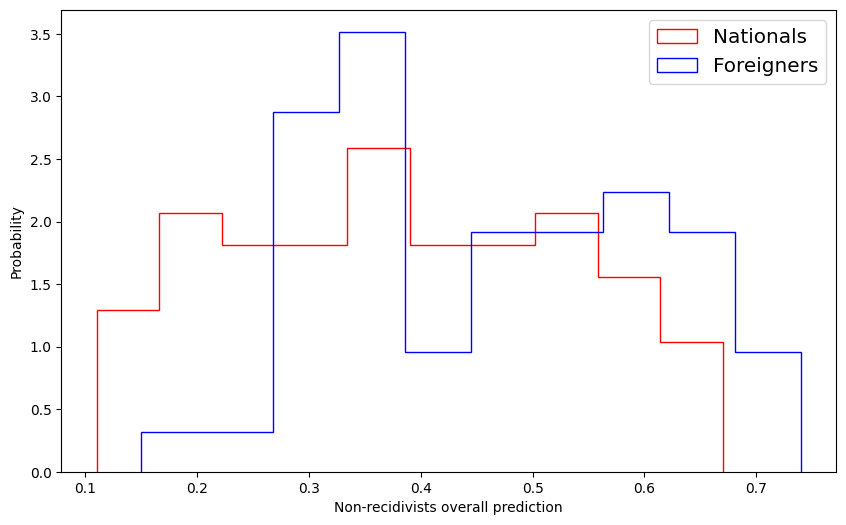

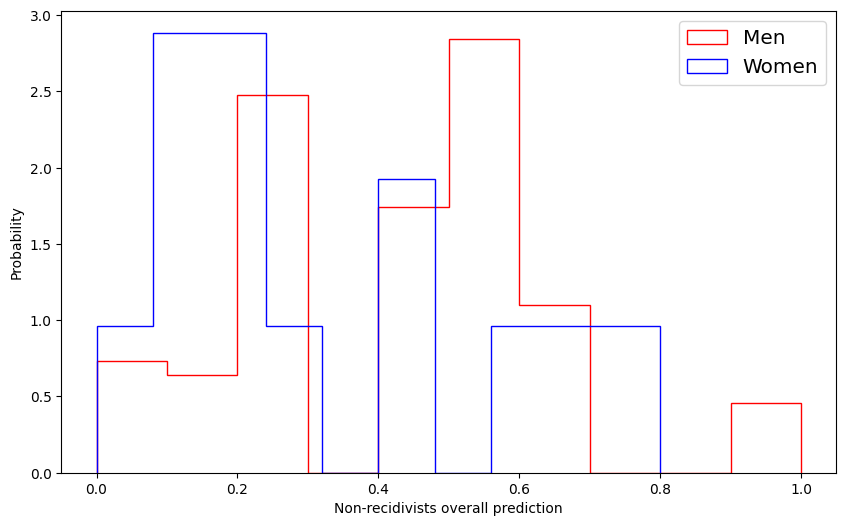

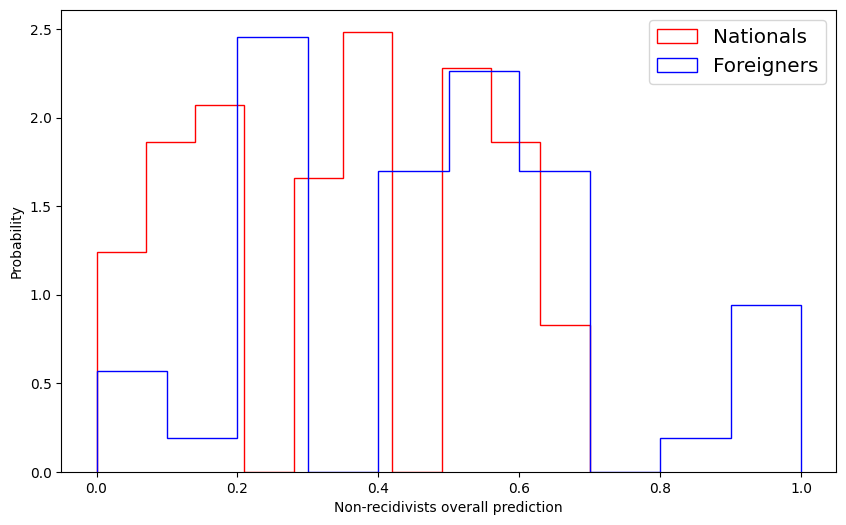

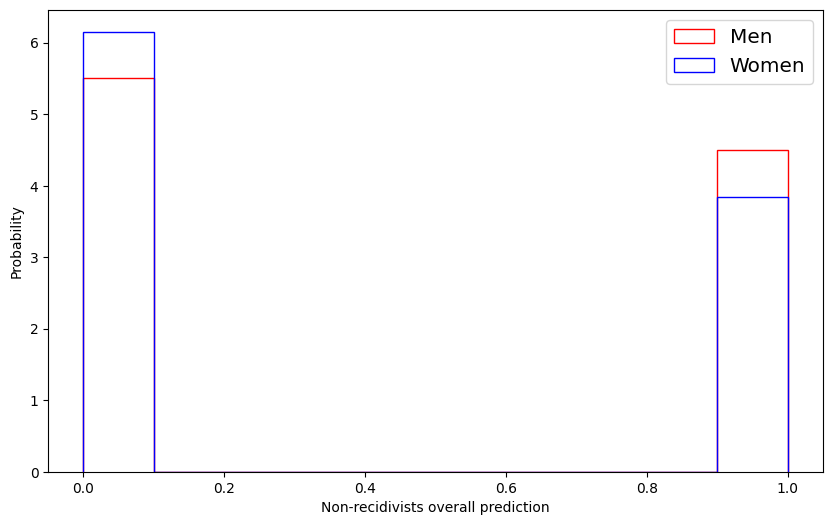

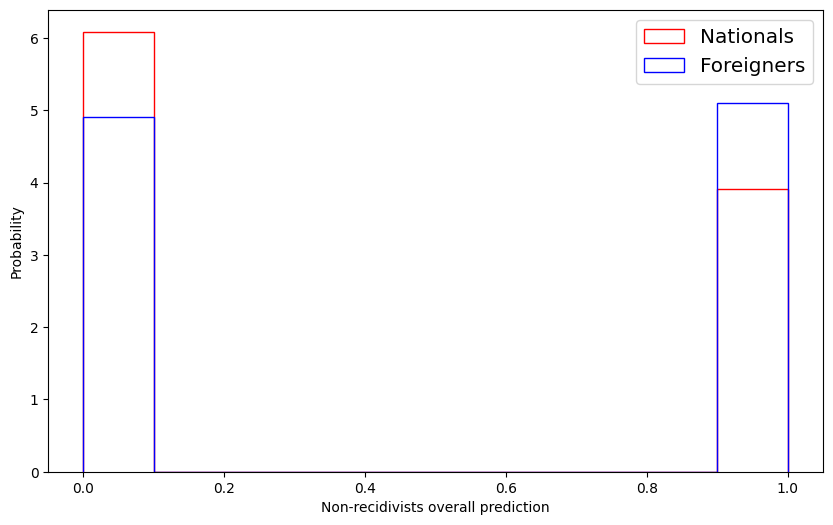

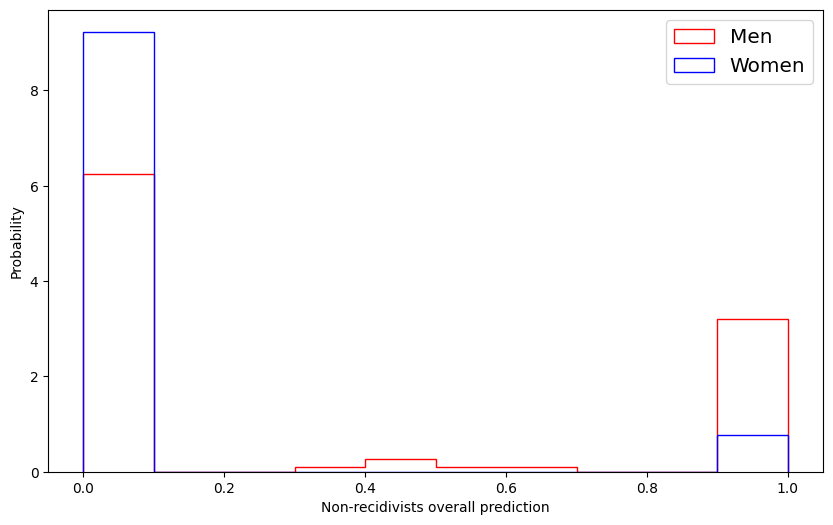

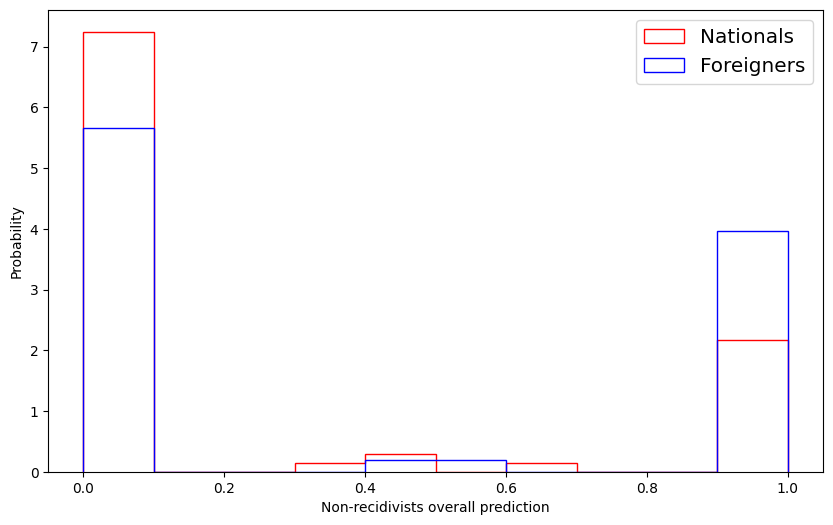

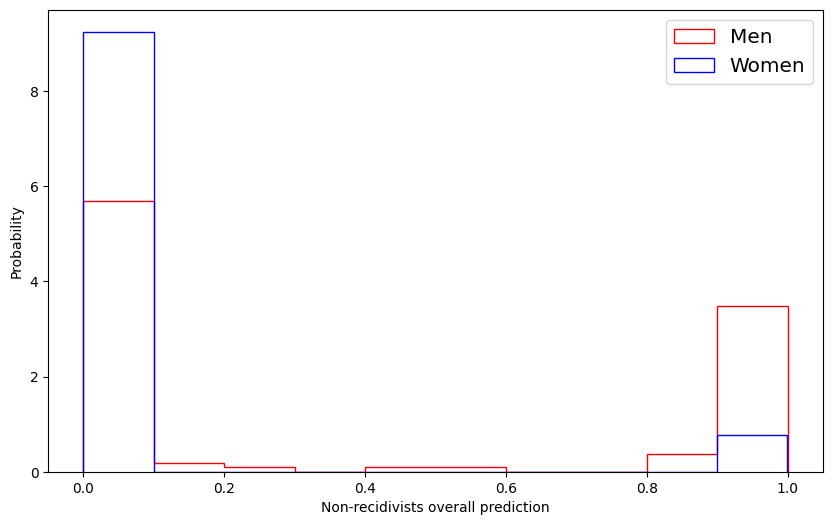

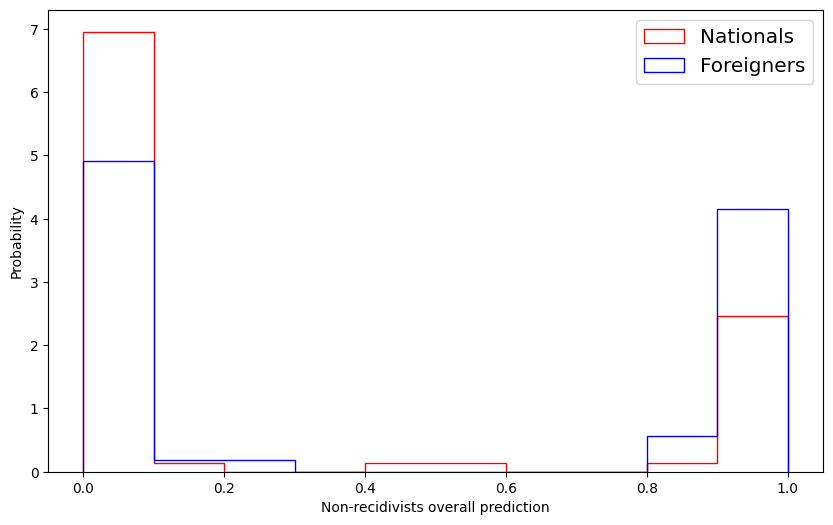

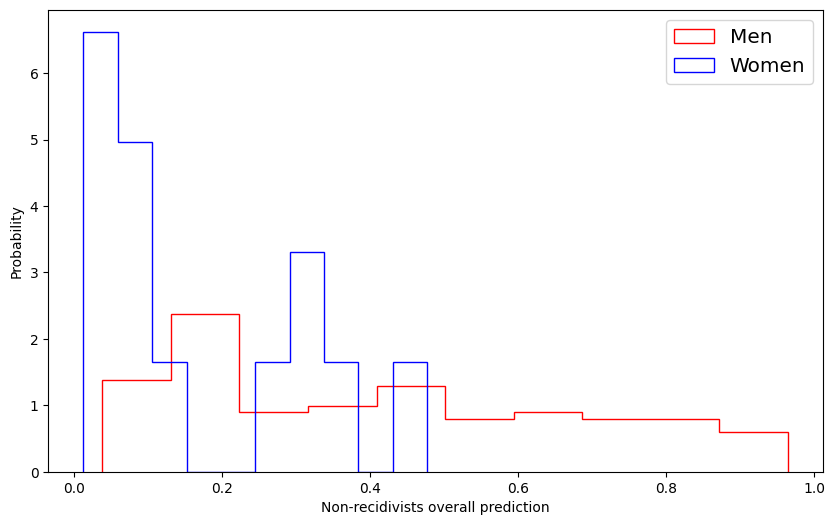

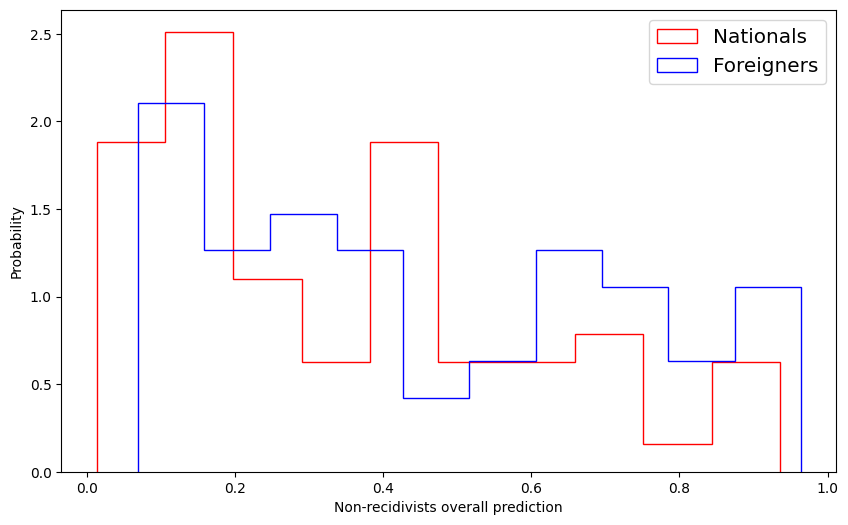

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


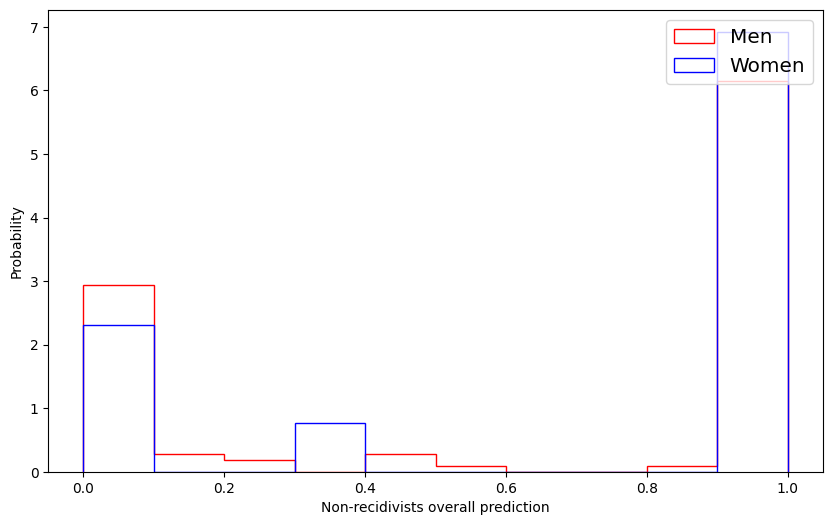

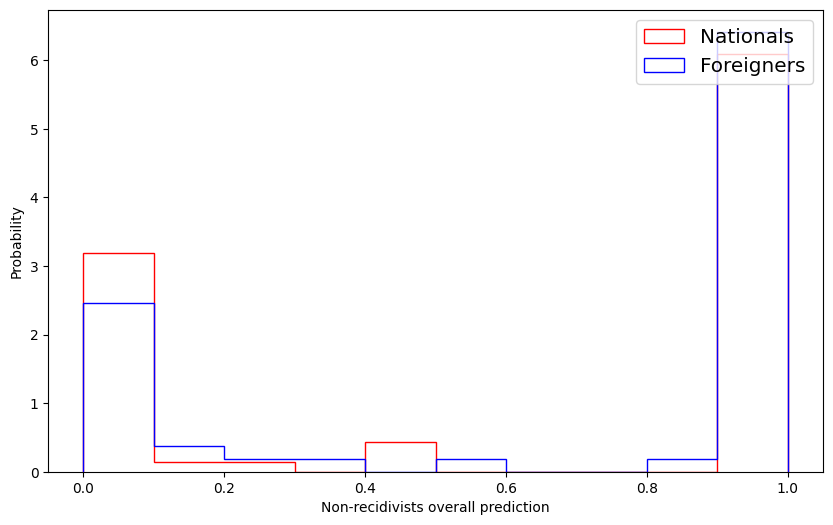

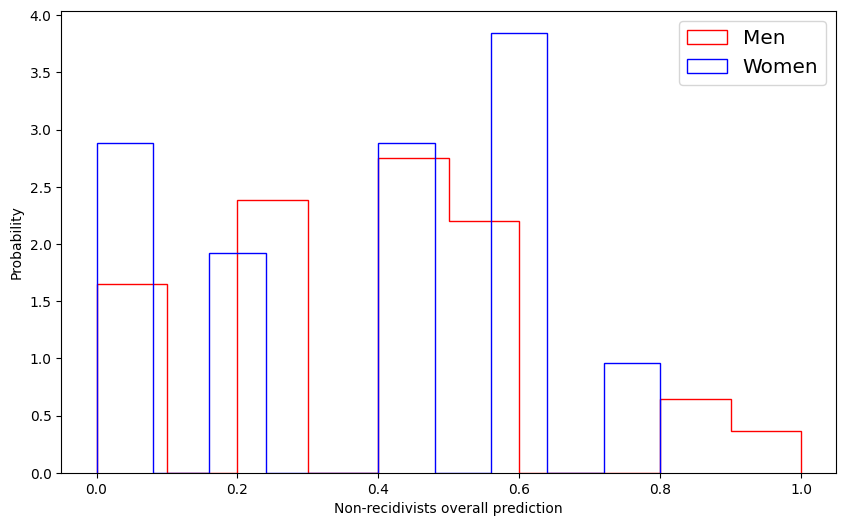

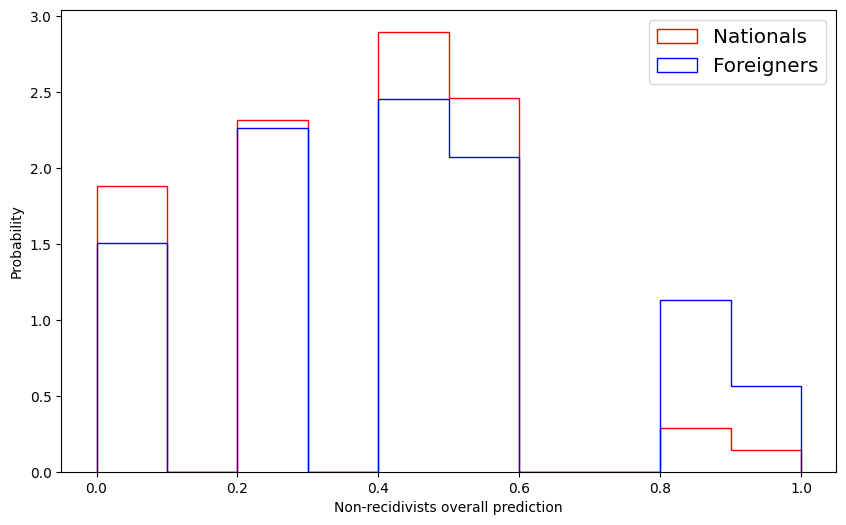

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


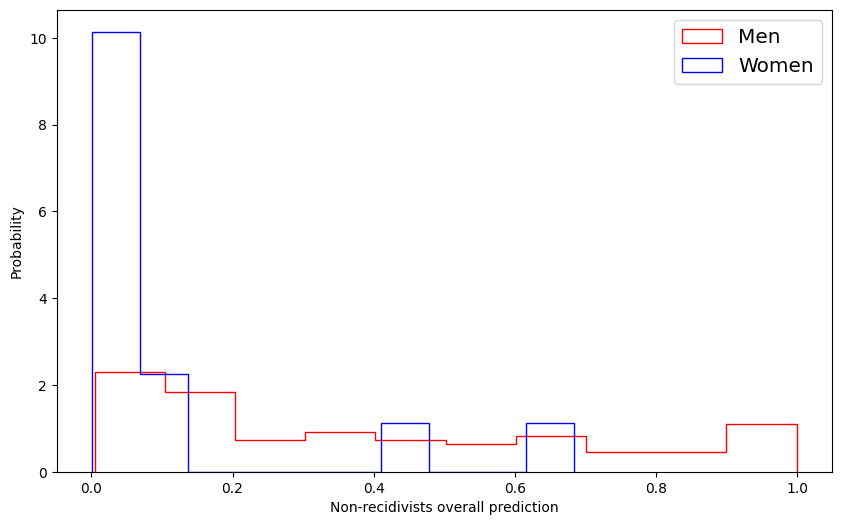

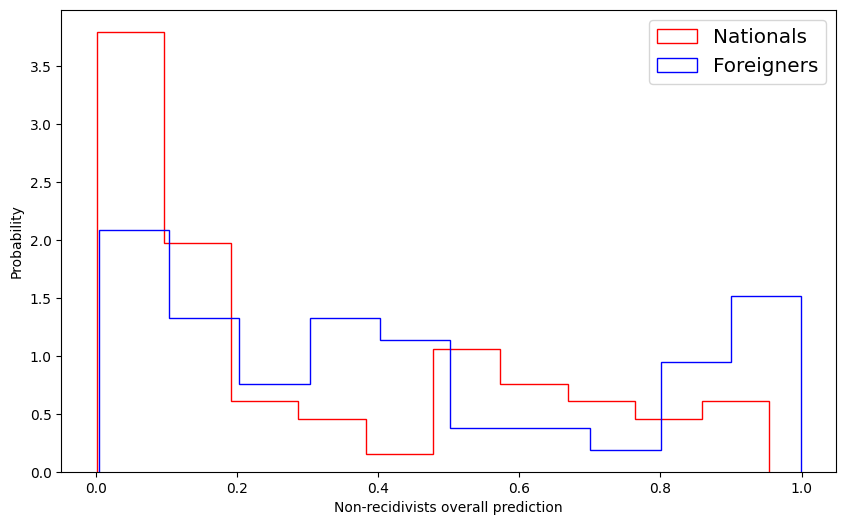

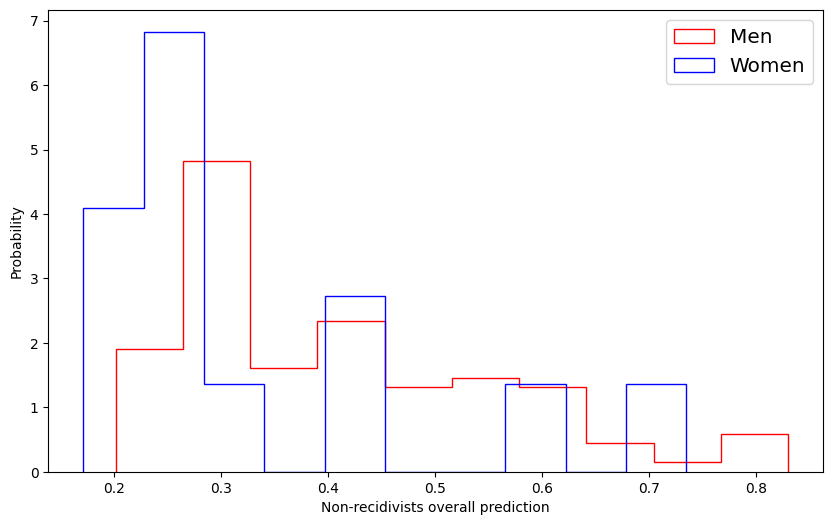

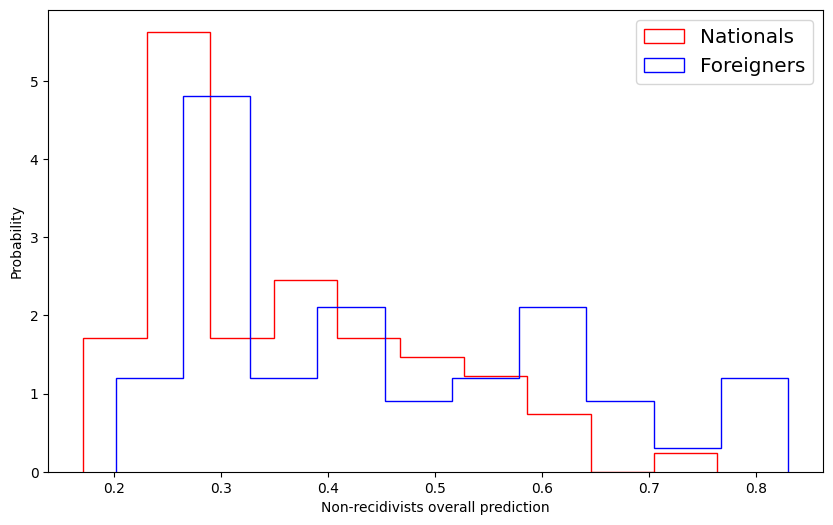

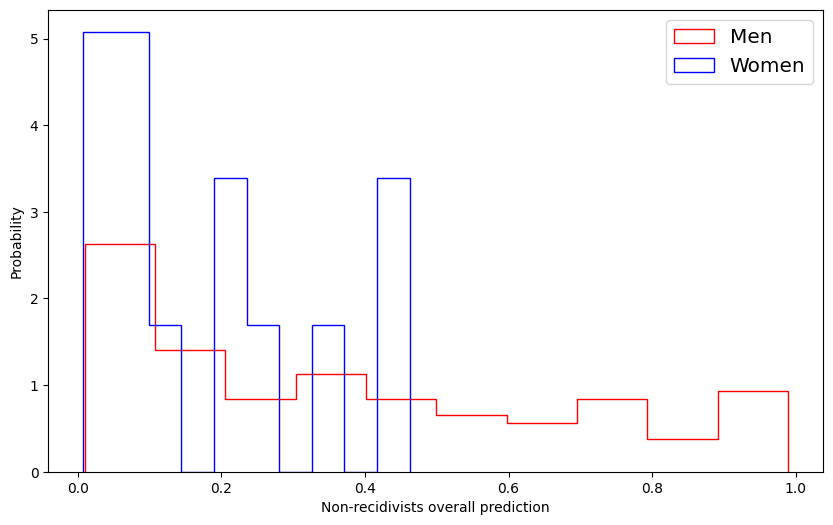

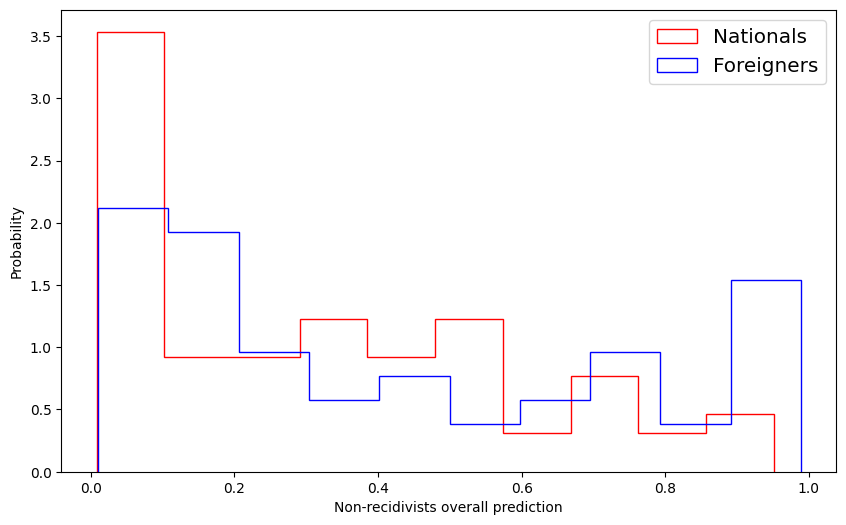

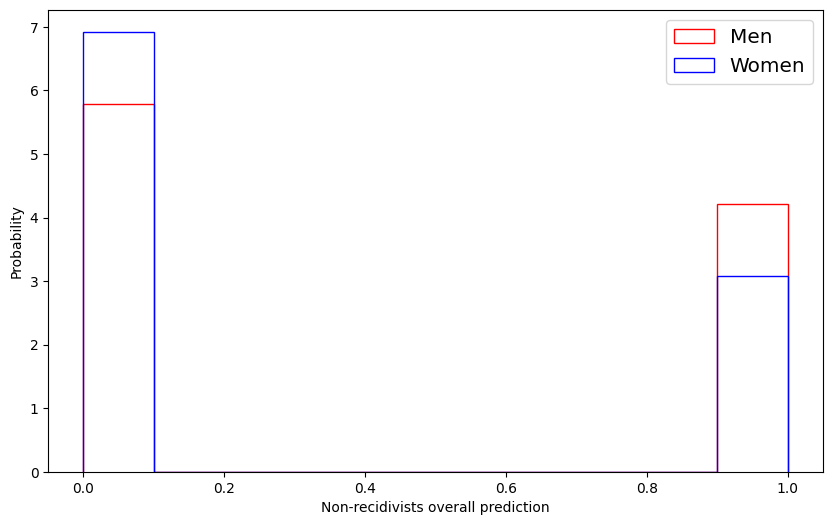

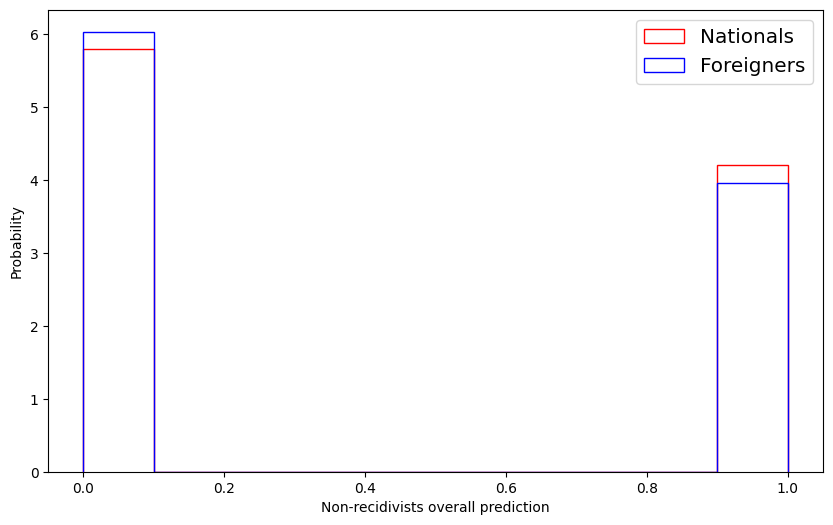

In [56]:
avg_prob_men_non_recid = []
avg_prob_women_non_recid = []
gender_bias = []
avg_prob_national_non_recid = []
avg_prob_foreigner_non_recid = []
nationality_bias = []
total_bias = []

# Train and evaluate each model
for model in models:
    # Train the model
    model.fit(train_X, train_y)
    # Compute the fairness criteria metrics: non-recidivist manVSwomen
    pred_y = model.predict_proba(test_X)[:,1]
    pred_men_non_recidivists = pred_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
    pred_women_non_recidivists = pred_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]
    avg_prob_men_non_recid.append((pred_men_non_recidivists.sum() / len(pred_men_non_recidivists)))
    avg_prob_women_non_recid.append((pred_women_non_recidivists.sum() / len(pred_women_non_recidivists)))
    gender_bias.append(abs(avg_prob_men_non_recid[-1]-avg_prob_women_non_recid[-1]))
    compare_histograms(pred_men_non_recidivists, pred_women_non_recidivists, "Non-recidivists overall prediction", label1="Men", label2="Women")
    # Compute the fairness criteria metrics: non-recidivist nationalVSforeigners
    pred_nationals_non_recidivists = pred_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
    pred_foreigners_non_recidivists = pred_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
    avg_prob_national_non_recid.append((pred_nationals_non_recidivists.sum() / len(pred_nationals_non_recidivists))) 
    avg_prob_foreigner_non_recid.append((pred_foreigners_non_recidivists.sum() / len(pred_foreigners_non_recidivists)))
    nationality_bias.append(abs(avg_prob_national_non_recid[-1]-avg_prob_foreigner_non_recid[-1]))
    total_bias.append(gender_bias[-1]+nationality_bias[-1])
    compare_histograms(pred_nationals_non_recidivists, pred_foreigners_non_recidivists, "Non-recidivists overall prediction", label1="Nationals", label2="Foreigners")

In [57]:
d = {'model': models_names, 'ROC_AUC': roc_aucs, 
     'avg_men': avg_prob_men_non_recid, 'avg_women': avg_prob_women_non_recid, '|Gender_Bias|': gender_bias, 
     'avg_national': avg_prob_national_non_recid, 'avg_foreigner': avg_prob_foreigner_non_recid, '|Nationality_Bias|': nationality_bias,
     '|Total_Bias|': total_bias}
df_biases = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_biases.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
to_highlight = ['|Gender_Bias|', '|Nationality_Bias|', '|Total_Bias|']
df_styled = df_styled.highlight_min(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC,avg_men,avg_women,|Gender_Bias|,avg_national,avg_foreigner,|Nationality_Bias|,|Total_Bias|
0,LogisticRegression,0.645637,0.413272,0.179091,0.234181,0.339990,0.451236,0.111246,0.345427
1,AdaBoostClassifier,0.643761,0.498718,0.489355,0.009363,0.495466,0.500655,0.005189,0.014552
2,GradientBoostingClassifier,0.636783,0.395569,0.216812,0.178757,0.356812,0.402180,0.045369,0.224125
3,RandomForestClassifier,0.649559,0.425688,0.330000,0.095688,0.382609,0.458302,0.075693,0.171381
4,BaggingClassifier,0.609206,0.411927,0.315385,0.096542,0.344928,0.475472,0.130544,0.227086
5,ExtraTreeClassifier,0.542177,0.449541,0.384615,0.064926,0.391304,0.509434,0.118130,0.183056
6,SGDClassifier,0.618623,0.347956,0.076923,0.271032,0.246304,0.413815,0.167510,0.438543
7,GaussianNB,0.665195,0.392184,0.077625,0.314559,0.278017,0.463660,0.185643,0.500202
8,LinearDiscriminantAnalysis,0.641770,0.413123,0.171034,0.242089,0.339968,0.448982,0.109014,0.351103
9,QuadraticDiscriminantAnalysis,0.607431,0.648421,0.717275,0.068854,0.632962,0.685435,0.052473,0.121327


Once again we do so applying a cross-validation routine to obtain more consistent results

In [58]:
cross_validation_instances = 10
avg_prob_men_non_recid = np.zeros([len(models_names), cross_validation_instances])
avg_prob_women_non_recid = np.zeros([len(models_names), cross_validation_instances])
gender_bias = np.zeros([len(models_names), cross_validation_instances])
avg_prob_national_non_recid = np.zeros([len(models_names), cross_validation_instances])
avg_prob_foreigner_non_recid = np.zeros([len(models_names), cross_validation_instances])
nationality_bias = np.zeros([len(models_names), cross_validation_instances])
total_bias = np.zeros([len(models_names), cross_validation_instances])

for i in range(cross_validation_instances): 
    train, test = train_test_split(df, test_size=0.33)

    train_X = pd.get_dummies(train[factors])
    train_y = train["V115_reincidencia_2015"]

    test_X = pd.get_dummies(test[factors])
    test_y = test["V115_reincidencia_2015"]

    # Train and evaluate each model
    for j in range(len(models)):
        # Train the model
        models[j].fit(train_X, train_y)
        pred_y = models[j].predict_proba(test_X)[:,1]
        pred_men_non_recidivists = pred_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
        pred_women_non_recidivists = pred_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]
        avg_prob_men_non_recid[j,i] = (pred_men_non_recidivists.sum() / len(pred_men_non_recidivists))
        avg_prob_women_non_recid[j,i] = (pred_women_non_recidivists.sum() / len(pred_women_non_recidivists))
        gender_bias[j,i] = abs(avg_prob_men_non_recid[j,i]-avg_prob_women_non_recid[j,i])
        # Compute the fairness criteria metrics: non-recidivist nationalVSforeigners
        pred_nationals_non_recidivists = pred_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
        pred_foreigners_non_recidivists = pred_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
        avg_prob_national_non_recid[j,i] = (pred_nationals_non_recidivists.sum() / len(pred_nationals_non_recidivists))
        avg_prob_foreigner_non_recid[j,i] = (pred_foreigners_non_recidivists.sum() / len(pred_foreigners_non_recidivists))
        nationality_bias[j,i] = abs(avg_prob_national_non_recid[j,i]-avg_prob_foreigner_non_recid[j,i])
        total_bias[j,i] = gender_bias[j,i]+nationality_bias[j,i]

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_mult

In [59]:
avg_prob_men_non_recid = np.mean(avg_prob_men_non_recid, axis=1)
avg_prob_women_non_recid = np.mean(avg_prob_women_non_recid, axis=1)
gender_bias = np.mean(gender_bias, axis=1)
avg_prob_national_non_recid = np.mean(avg_prob_national_non_recid, axis=1)
avg_prob_foreigner_non_recid = np.mean(avg_prob_foreigner_non_recid, axis=1)
nationality_bias = np.mean(nationality_bias, axis=1)
total_bias = np.mean(total_bias, axis=1)

d = {'model': models_names, 'ROC_AUC': roc_aucs, 
     'avg_men': avg_prob_men_non_recid, 'avg_women': avg_prob_women_non_recid, '|Gender_Bias|': gender_bias, 
     'avg_national': avg_prob_national_non_recid, 'avg_foreigner': avg_prob_foreigner_non_recid, '|Nationality_Bias|': nationality_bias,
     '|Total_Bias|': total_bias}
df_biases = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_biases.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
to_highlight = ['|Gender_Bias|', '|Nationality_Bias|', '|Total_Bias|']
df_styled = df_styled.highlight_min(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC,avg_men,avg_women,|Gender_Bias|,avg_national,avg_foreigner,|Nationality_Bias|,|Total_Bias|
0,LogisticRegression,0.645637,0.396804,0.210531,0.186273,0.327057,0.437985,0.111604,0.297877
1,AdaBoostClassifier,0.643761,0.498048,0.491549,0.006499,0.495607,0.499471,0.003864,0.010363
2,GradientBoostingClassifier,0.636783,0.392365,0.250933,0.141432,0.326956,0.446345,0.119389,0.260821
3,RandomForestClassifier,0.649559,0.407234,0.344376,0.062857,0.373574,0.440228,0.066654,0.129511
4,BaggingClassifier,0.609206,0.403291,0.340624,0.064731,0.370963,0.432651,0.061688,0.126420
5,ExtraTreeClassifier,0.542177,0.393146,0.341852,0.079044,0.366161,0.410790,0.089685,0.168729
6,SGDClassifier,0.618623,0.394746,0.188252,0.206495,0.311776,0.453898,0.146693,0.353188
7,GaussianNB,0.665195,0.376265,0.123929,0.252336,0.293302,0.413694,0.120392,0.372728
8,LinearDiscriminantAnalysis,0.641770,0.389092,0.215336,0.173756,0.323511,0.428082,0.108264,0.282020
9,QuadraticDiscriminantAnalysis,0.607431,0.582781,0.513782,0.154006,0.532913,0.639074,0.115175,0.269181


As we would expect, the best performing model is not the one that achieve the best bias scores. The model that consistently achieves the best bias scores between the considered ones is the AdaBoostClassifier, at the cost of a worse performance, even though still acceptable.

## 1.3 Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

For this part we'll directly present the results obtained using the cross-validation routine

* Demographic Parity requires to have the same *Positive Rate* for each protected group
$$\mathbb{P}(\hat{Y}=1|X\in G^+) = \mathbb{P}(\hat{Y}=1|X\in G^-)$$
Meaning we focus on the single subgroup and ask that our predictions are with a similar rate, $\underline{\text{regardless of the number of samples in each subgroup and their actual label}}$

In [60]:
cross_validation_instances = 10
avg_pred_men = np.zeros([len(models_names), cross_validation_instances])
avg_pred_women = np.zeros([len(models_names), cross_validation_instances])
gender_bias = np.zeros([len(models_names), cross_validation_instances])
avg_pred_nationals = np.zeros([len(models_names), cross_validation_instances])
avg_pred_foreigners = np.zeros([len(models_names), cross_validation_instances])
nationality_bias = np.zeros([len(models_names), cross_validation_instances])
total_bias = np.zeros([len(models_names), cross_validation_instances])

for i in range(cross_validation_instances): 
    train, test = train_test_split(df, test_size=0.33)

    train_X = pd.get_dummies(train[factors])
    train_y = train["V115_reincidencia_2015"]

    test_X = pd.get_dummies(test[factors])
    test_y = test["V115_reincidencia_2015"]

    # Train and evaluate each model
    for j in range(len(models)):
        # Train the model
        models[j].fit(train_X, train_y)
        # Compute the fairness criteria metrics: non-recidivist manVSwomen
        pred_y = models[j].predict_proba(test_X)[:,1]
        pred_men = pred_y[(test_X["V1_sexe_Home"]==1)]
        pred_women = pred_y[(test_X["V1_sexe_Dona"]==1)]
        avg_pred_men[j,i] = (pred_men.sum() / len(pred_men))
        avg_pred_women[j,i] = (pred_women.sum() / len(pred_women))
        gender_bias[j,i] = abs(avg_pred_men[j,i]-avg_pred_women[j,i])
        # Compute the fairness criteria metrics: non-recidivist nationalVSforeigners
        pred_nationals = pred_y[(test_X["V2_estranger_Espanyol"]==1)]
        pred_foreigners = pred_y[(test_X["V2_estranger_Estranger"]==1)]
        avg_pred_nationals[j,i] = (pred_nationals.sum() / len(pred_nationals))
        avg_pred_foreigners[j,i] = (pred_foreigners.sum() / len(pred_foreigners))
        nationality_bias[j,i] = abs(avg_pred_nationals[j,i]-avg_pred_foreigners[j,i])
        total_bias[j,i] = gender_bias[j,i]+nationality_bias[j,i]

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_mult

In [61]:
avg_pred_men = np.mean(avg_pred_men, axis=1)
avg_pred_women = np.mean(avg_pred_women, axis=1)
gender_bias = np.mean(gender_bias, axis=1)
avg_pred_nationals = np.mean(avg_pred_nationals, axis=1)
avg_pred_foreigners = np.mean(avg_pred_foreigners, axis=1)
nationality_bias = np.mean(nationality_bias, axis=1)
total_bias = np.mean(total_bias, axis=1)

d = {'model': models_names, 'ROC_AUC': roc_aucs, 
     'avg_men': avg_pred_men, 'avg_women': avg_pred_women, '|Gender_Bias|': gender_bias, 
     'avg_national': avg_pred_nationals, 'avg_foreigner': avg_pred_foreigners, '|Nationality_Bias|': nationality_bias,
     '|Total_Bias|': total_bias}
df_biases = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_biases.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
to_highlight = ['|Gender_Bias|', '|Nationality_Bias|', '|Total_Bias|']
df_styled = df_styled.highlight_min(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC,avg_men,avg_women,|Gender_Bias|,avg_national,avg_foreigner,|Nationality_Bias|,|Total_Bias|
0,LogisticRegression,0.645637,0.444022,0.248402,0.195619,0.360078,0.503409,0.143331,0.338951
1,AdaBoostClassifier,0.643761,0.499248,0.492713,0.006534,0.496995,0.500476,0.003491,0.010026
2,GradientBoostingClassifier,0.636783,0.442267,0.284475,0.157791,0.372628,0.493708,0.121080,0.278871
3,RandomForestClassifier,0.649559,0.436396,0.352834,0.083562,0.391658,0.475412,0.083755,0.167316
4,BaggingClassifier,0.609206,0.453294,0.373842,0.079452,0.414750,0.482603,0.067853,0.147305
5,ExtraTreeClassifier,0.542177,0.451279,0.356600,0.100148,0.410554,0.484930,0.100656,0.200804
6,SGDClassifier,0.618623,0.259974,0.097112,0.162861,0.184518,0.319891,0.135372,0.298234
7,GaussianNB,0.665195,0.471985,0.169278,0.302707,0.370268,0.523636,0.153368,0.456075
8,LinearDiscriminantAnalysis,0.641770,0.438589,0.257831,0.180758,0.356727,0.499640,0.142913,0.323671
9,QuadraticDiscriminantAnalysis,0.607431,0.553333,0.423574,0.131114,0.497695,0.595120,0.097425,0.228539


* Equal Opportunity requires to have the same *True Positive Rate* over each protected group
$$\mathbb{P}(\hat{Y}=1|Y=1,X\in G^+) = \mathbb{P}(\hat{Y}=1|Y=1,X\in G^-)$$
Meaning we focus on the single subgroup with positive labels and ask that our predictions are with a similar rate. (True Positive Rate) 
$\underline{\text{similarly to Demographic Parity we want the same chance on the subgroups, but only when the members qualify}}$

In [62]:
cross_validation_instances = 10
avg_pred_men = np.zeros([len(models_names), cross_validation_instances])
avg_pred_women = np.zeros([len(models_names), cross_validation_instances])
gender_bias = np.zeros([len(models_names), cross_validation_instances])
avg_pred_nationals = np.zeros([len(models_names), cross_validation_instances])
avg_pred_foreigners = np.zeros([len(models_names), cross_validation_instances])
nationality_bias = np.zeros([len(models_names), cross_validation_instances])
total_bias = np.zeros([len(models_names), cross_validation_instances])

for i in range(cross_validation_instances): 
    train, test = train_test_split(df, test_size=0.33)

    train_X = pd.get_dummies(train[factors])
    train_y = train["V115_reincidencia_2015"]

    test_X = pd.get_dummies(test[factors])
    test_y = test["V115_reincidencia_2015"]

    # Train and evaluate each model
    for j in range(len(models)):
        # Train the model
        models[j].fit(train_X, train_y)
        # Compute the fairness criteria metrics: non-recidivist manVSwomen
        pred_y = models[j].predict_proba(test_X)[:,1]
        pred_men = pred_y[(test_y=='Sí') & (test_X["V1_sexe_Home"]==1)]
        pred_women = pred_y[(test_y=='Sí') & (test_X["V1_sexe_Dona"]==1)]
        avg_pred_men[j,i] = (pred_men.sum() / len(pred_men))
        avg_pred_women[j,i] = (pred_women.sum() / len(pred_women))
        gender_bias[j,i] = abs(avg_pred_men[j,i]-avg_pred_women[j,i])
        # Compute the fairness criteria metrics: non-recidivist nationalVSforeigners
        pred_nationals = pred_y[(test_y=='Sí') & (test_X["V2_estranger_Espanyol"]==1)]
        pred_foreigners = pred_y[(test_y=='Sí') & (test_X["V2_estranger_Estranger"]==1)]
        avg_pred_nationals[j,i] = (pred_nationals.sum() / len(pred_nationals))
        avg_pred_foreigners[j,i] = (pred_foreigners.sum() / len(pred_foreigners))
        nationality_bias[j,i] = abs(avg_pred_nationals[j,i]-avg_pred_foreigners[j,i])
        total_bias[j,i] = gender_bias[j,i]+nationality_bias[j,i]

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_mult

In [63]:
avg_pred_men = np.mean(avg_pred_men, axis=1)
avg_pred_women = np.mean(avg_pred_women, axis=1)
gender_bias = np.mean(gender_bias, axis=1)
avg_pred_nationals = np.mean(avg_pred_nationals, axis=1)
avg_pred_foreigners = np.mean(avg_pred_foreigners, axis=1)
nationality_bias = np.mean(nationality_bias, axis=1)
total_bias = np.mean(total_bias, axis=1)

d = {'model': models_names, 'ROC_AUC': roc_aucs, 
     'avg_men': avg_pred_men, 'avg_women': avg_pred_women, '|Gender_Bias|': gender_bias, 
     'avg_national': avg_pred_nationals, 'avg_foreigner': avg_pred_foreigners, '|Nationality_Bias|': nationality_bias,
     '|Total_Bias|': total_bias}
df_biases = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_biases.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
to_highlight = ['|Gender_Bias|', '|Nationality_Bias|', '|Total_Bias|']
df_styled = df_styled.highlight_min(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC,avg_men,avg_women,|Gender_Bias|,avg_national,avg_foreigner,|Nationality_Bias|,|Total_Bias|
0,LogisticRegression,0.645637,0.534003,0.310497,0.223506,0.458480,0.589143,0.130663,0.354169
1,AdaBoostClassifier,0.643761,0.502240,0.494280,0.007961,0.500388,0.503297,0.004782,0.012742
2,GradientBoostingClassifier,0.636783,0.517187,0.304378,0.212809,0.446437,0.570643,0.124205,0.337015
3,RandomForestClassifier,0.649559,0.484362,0.414225,0.070137,0.452606,0.511362,0.058755,0.128892
4,BaggingClassifier,0.609206,0.489981,0.434583,0.093902,0.458947,0.520928,0.062120,0.156022
5,ExtraTreeClassifier,0.542177,0.457827,0.431389,0.138368,0.423573,0.497448,0.110466,0.248834
6,SGDClassifier,0.618623,0.604692,0.420797,0.183894,0.526255,0.668015,0.141759,0.325654
7,GaussianNB,0.665195,0.591196,0.397938,0.193258,0.518196,0.643415,0.125219,0.318478
8,LinearDiscriminantAnalysis,0.641770,0.530886,0.319846,0.211040,0.456880,0.586402,0.129522,0.340563
9,QuadraticDiscriminantAnalysis,0.607431,0.698770,0.617942,0.127358,0.666661,0.722814,0.082103,0.209462


* Equalized Odds requires to have the same *True Positive Rate* and the same *False Positive Rate* over each group

In [64]:
cross_validation_instances = 10
avg_pred_men = np.zeros([len(models_names), cross_validation_instances])
avg_pred_women = np.zeros([len(models_names), cross_validation_instances])
gender_bias = np.zeros([len(models_names), cross_validation_instances])
avg_pred_nationals = np.zeros([len(models_names), cross_validation_instances])
avg_pred_foreigners = np.zeros([len(models_names), cross_validation_instances])
nationality_bias = np.zeros([len(models_names), cross_validation_instances])
total_bias = np.zeros([len(models_names), cross_validation_instances])

for i in range(cross_validation_instances): 
    train, test = train_test_split(df, test_size=0.33)

    train_X = pd.get_dummies(train[factors])
    train_y = train["V115_reincidencia_2015"]

    test_X = pd.get_dummies(test[factors])
    test_y = test["V115_reincidencia_2015"]

    # Train and evaluate each model
    for j in range(len(models)):
        # Train the model
        models[j].fit(train_X, train_y)
        # Compute the fairness criteria metrics: non-recidivist manVSwomen
        pred_y = models[j].predict_proba(test_X)[:,1]
        pred_men = pred_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
        pred_women = pred_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]
        avg_pred_men[j,i] = (pred_men.sum() / len(pred_men))
        avg_pred_women[j,i] = (pred_women.sum() / len(pred_women))
        gender_bias[j,i] = abs(avg_pred_men[j,i]-avg_pred_women[j,i])
        # Compute the fairness criteria metrics: non-recidivist nationalVSforeigners
        pred_nationals = pred_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
        pred_foreigners = pred_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
        avg_pred_nationals[j,i] = (pred_nationals.sum() / len(pred_nationals))
        avg_pred_foreigners[j,i] = (pred_foreigners.sum() / len(pred_foreigners))
        nationality_bias[j,i] = abs(avg_pred_nationals[j,i]-avg_pred_foreigners[j,i])
        total_bias[j,i] = gender_bias[j,i]+nationality_bias[j,i]

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_mult

In [65]:
avg_pred_men = np.mean(avg_pred_men, axis=1)
avg_pred_women = np.mean(avg_pred_women, axis=1)
gender_bias = np.mean(gender_bias, axis=1)
avg_pred_nationals = np.mean(avg_pred_nationals, axis=1)
avg_pred_foreigners = np.mean(avg_pred_foreigners, axis=1)
nationality_bias = np.mean(nationality_bias, axis=1)
total_bias = np.mean(total_bias, axis=1)

d = {'model': models_names, 'ROC_AUC': roc_aucs, 
     'avg_men': avg_pred_men, 'avg_women': avg_pred_women, '|Gender_Bias|': gender_bias, 
     'avg_national': avg_pred_nationals, 'avg_foreigner': avg_pred_foreigners, '|Nationality_Bias|': nationality_bias,
     '|Total_Bias|': total_bias}
df_biases = pd.DataFrame(data=d)
to_highlight = ['ROC_AUC']
df_styled = df_biases.style.highlight_max(subset = to_highlight, color = 'lightgreen', axis = 0)
to_highlight = ['|Gender_Bias|', '|Nationality_Bias|', '|Total_Bias|']
df_styled = df_styled.highlight_min(subset = to_highlight, color = 'lightgreen', axis = 0)
df_styled

,model,ROC_AUC,avg_men,avg_women,|Gender_Bias|,avg_national,avg_foreigner,|Nationality_Bias|,|Total_Bias|
0,LogisticRegression,0.645637,0.408655,0.221765,0.186890,0.340309,0.444113,0.103804,0.290694
1,AdaBoostClassifier,0.643761,0.498557,0.492444,0.006113,0.495925,0.500580,0.004656,0.010768
2,GradientBoostingClassifier,0.636783,0.394511,0.277341,0.117170,0.339072,0.441801,0.102729,0.219899
3,RandomForestClassifier,0.649559,0.400313,0.347642,0.052740,0.368835,0.433838,0.065004,0.117743
4,BaggingClassifier,0.609206,0.403615,0.341695,0.069994,0.365083,0.442672,0.081491,0.151485
5,ExtraTreeClassifier,0.542177,0.448526,0.301085,0.170094,0.404617,0.465768,0.083661,0.253755
6,SGDClassifier,0.618623,0.494502,0.309588,0.184914,0.423693,0.531078,0.107385,0.292299
7,GaussianNB,0.665195,0.377769,0.109293,0.268476,0.303465,0.388424,0.102931,0.371407
8,LinearDiscriminantAnalysis,0.641770,0.401934,0.225840,0.176094,0.337603,0.434715,0.097112,0.273206
9,QuadraticDiscriminantAnalysis,0.607431,0.594642,0.536652,0.093892,0.561110,0.631454,0.070344,0.164235


* Conditional Demographic Parity requires to obtain Demographic Parity after conditioning on attributes that define strata of subgrups on the dataset. $\underline{\text{This allows to rule out Simpson's paradox}}$

## Answers to the questions

1. Is there a method that can achieve better predictive power than human experts? 

Some models achieve good results in terms of predictive power. From the validation of the considered models over 10 different train/test splits, the best result is achieved by an SVM model, scoring around a 0.69 AUC of the Receiver Operating Characteristic curve, compared to the 0.64 of the initially proposed Logistic Regression and the 0.63 of the SAVRY score. Making a comparison with the human experts predictive power with the available information if a bit challenging in this case, since the given human expert score is simply divided into Low, Medium, and High probability of recidivism. In order to do so, we could assign numerical scores to these three classes or train the models for a multiclass classification. However, these two techniques strongly hinder one of the two parts, thus making the comparison less relevant. </br> </br>

2. Is this method better than human experts in terms of fairness?

Recalling that the bias measure of the human expert was of 0.012, 0.015, and 0.027 for Sex bias, Nationality bias, and Total bias respectively, we can observe that the SVM model achieves worse scores with 0.050, 0.054, 0.104 respectively. However, if we focus on bias minimization and consider the model with the best bias scores, at the cost of scoring around 0.651 for the AUC, we can see that the scores of the AdaBoostClassifier are even lower than the human expert, being around 0.006, 0.004, and 0.010 respectively. </br> </br>

3. Which is the most suited fairness criterium for this problem? Why?

For this problem we are trying to assign a score for the probability of recidivism of a previously convicted person. We need to take into consideration that for our conception of the Law, we consider people to be innocent until proven guilty. For this reason, a larger effort should be made to minimize wrongly assigned high scores to people who shouldn't receive one, meaning we should prioritize minimizing the difference in False Positive rates over different protected subgroups conditioned to the true label being positive. We thus seek to obtain Equal Opportunity

$$\mathbb{P}(\hat{Y}=1|Y=1,X\in G^+) = \mathbb{P}(\hat{Y}=1|Y=1,X\in G^-)$$

</br>

4. What are your conclusion about the use of a ML model to predict recividism?

If well optimized in terms of bias measures, a ML model can be of considerable help in predicting recidivism. In terms of predictive power and accuracy it is difficult to tell if it could achieve a better performance than an human expert, with the given data, but if used as a tool of reference and assistance to an human expert, in my opinion, it can only improve the possibilities of giving more accurate and fair opinions. Also, putting effort in training the model in order to minimize the most undesirable errors specific to the problem, can allow to obtain a more fair and less punishing model. (such as maximizing different metrics, like specificity or precision, to minimize False Positives) </br> </br>


# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

## 1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

Wanting to apply this method to both sex and natonality we need to considee that changing the number of samples of one group, will also affect the number of samples in the other group. This is true both in the case of oversampling, as well as in the case of using a weighted loss function. In order to solve this, we can apply the same logic but to subgroup, slicing the dataset into 4 different subgroups that take into consideration the combinations of both sex and nationality. 
In the case of the sex bias we have 

$$S_i = P(x(sex)=Woman)(P(y|x(sex)=Woman) - P(y|x(sex)=Man))$$

while in the case of nationality we have 

$$S_i = P(x(nationality)=Foreigner)(P(y|x(nationality)=Foreigner) - P(y|x(nationality)=National))$$

In order to achieve Equalized Base Rates, we apply oversampling to the four subgroups, taking as reference group the group of National Men in order to achieve the above mentioned equalities. Notice that by distributing the product in the above equalities and applying the definition of conditional probability, we obtain the probability of the intersections of the subgroups, meaning to achieve the Equalized Base Rates we seek to obtain the same distribution for the labels over each subgroup. Instead of applying oversampling, since in this case using a good technique might prove to be challenging, we can apply sample weights to our samples, proportionally to $S_i$. Aternatively, duplicating the samples in each class achieves the analogous effect of reweighting.

In [89]:
ref_sex_nationality_1 = np.sum([(train_y=='Sí') & (train_X["V1_sexe_Home"]==1) & (train_X["V2_estranger_Espanyol"]==1)])
S1_sex_nationality_1 = np.sum([(train_y=='Sí') & (train_X["V1_sexe_Dona"]==1) & (train_X["V2_estranger_Espanyol"]==1)])
S2_sex_nationality_1 = np.sum([(train_y=='Sí') & (train_X["V1_sexe_Home"]==1) & (train_X["V2_estranger_Estranger"]==1)])
S3_sex_nationality_1 = np.sum([(train_y=='Sí') & (train_X["V1_sexe_Dona"]==1) & (train_X["V2_estranger_Estranger"]==1)])

print(ref_sex_nationality_1, S1_sex_nationality_1, S2_sex_nationality_1, S3_sex_nationality_1)

93 9 85 3


In [90]:
ref_sex_nationality_0 = np.sum([(train_y=='No') & (train_X["V1_sexe_Home"]==1) & (train_X["V2_estranger_Espanyol"]==1)])
S1_sex_nationality_0 = np.sum([(train_y=='No') & (train_X["V1_sexe_Dona"]==1) & (train_X["V2_estranger_Espanyol"]==1)])
S2_sex_nationality_0 = np.sum([(train_y=='No') & (train_X["V1_sexe_Home"]==1) & (train_X["V2_estranger_Estranger"]==1)])
S3_sex_nationality_0 = np.sum([(train_y=='No') & (train_X["V1_sexe_Dona"]==1) & (train_X["V2_estranger_Estranger"]==1)])

print(ref_sex_nationality_0, S1_sex_nationality_0, S2_sex_nationality_0, S3_sex_nationality_0)

138 29 70 8


In [87]:
ref_sex_1 = np.sum([(train_y=='Sí') & (train_X["V1_sexe_Home"]==1)]) / train_y.shape[0]
S1_sex_1 = np.sum([(train_y=='Sí') & (train_X["V1_sexe_Dona"]==1)]) / train_y.shape[0]
ref_sex_0 = np.sum([(train_y=='No') & (train_X["V1_sexe_Home"]==1)]) / train_y.shape[0]
S1_sex_0 = np.sum([(train_y=='No') & (train_X["V1_sexe_Dona"]==1)]) / train_y.shape[0]

print(ref_sex_1, S1_sex_1, ref_sex_0, S1_sex_0)

0.4091954022988506 0.027586206896551724 0.4781609195402299 0.08505747126436781


In [88]:
ref_nationality_1 = np.sum([(train_y=='Sí') & (train_X["V2_estranger_Espanyol"]==1)]) / train_y.shape[0]
S1_nationality_1 = np.sum([(train_y=='Sí') & (train_X["V2_estranger_Estranger"]==1)]) / train_y.shape[0]
ref_nationality_0 = np.sum([(train_y=='No') & (train_X["V2_estranger_Espanyol"]==1)]) / train_y.shape[0]
S1_nationality_0 = np.sum([(train_y=='No') & (train_X["V2_estranger_Estranger"]==1)]) / train_y.shape[0]

print(ref_nationality_1, S1_nationality_1, ref_nationality_0, S1_nationality_0)

0.23448275862068965 0.20229885057471264 0.3839080459770115 0.1793103448275862


In [92]:
gender_weights = np.zeros(train_y.shape[0])
gender_weights[(train_y=='Sí') & (train_X["V1_sexe_Home"]==1)] = 1 / ref_sex_1
gender_weights[(train_y=='Sí') & (train_X["V1_sexe_Dona"]==1)] = 1 / S1_sex_1
gender_weights[(train_y=='No') & (train_X["V1_sexe_Home"]==1)] = 1 / ref_sex_0
gender_weights[(train_y=='No') & (train_X["V1_sexe_Dona"]==1)] = 1 / S1_sex_0

nationality_weights = np.zeros(train_y.shape[0])
nationality_weights[(train_y=='Sí') & (train_X["V2_estranger_Espanyol"]==1)] = 1 / ref_nationality_1
nationality_weights[(train_y=='Sí') & (train_X["V2_estranger_Estranger"]==1)] = 1 / S1_nationality_1
nationality_weights[(train_y=='No') & (train_X["V2_estranger_Espanyol"]==1)] = 1 / ref_nationality_0
nationality_weights[(train_y=='No') & (train_X["V2_estranger_Estranger"]==1)] = 1 / S1_nationality_0

sample_weights = gender_weights * nationality_weights

We will apply this technique using sample weighting in the loss function during training in the next exercise. </br> </br>
Applying Equalized Base Rates (EBR) can be a useful mitigation method for reducing bias and promoting fairness in certain machine learning applications. EBR aims to ensure that the proportion of positive outcomes is equal across different subgroups of the population, such as different gender or racial groups.

However, EBR alone is not sufficient to guarantee fair outcomes in all cases. There are several reasons why EBR may not be enough:

Other types of bias: EBR only addresses bias related to differences in base rates across subgroups. There may be other types of bias, such as sampling bias, measurement bias, or selection bias, that are not addressed by EBR.

Contextual factors: EBR assumes that the underlying base rates are the same across all subgroups, which may not be true in all contexts. For example, the base rate of recidivism may be higher for certain subgroups due to historical, social, or economic factors.

Outcome disparities: Even if EBR is achieved, there may still be disparities in the outcomes for different subgroups. For example, achieving equal proportions of positive outcomes may not necessarily lead to equal treatment or opportunities for different subgroups.

Therefore, while EBR can be a useful tool for promoting fairness, it should be used in combination with other methods and techniques to address different types of bias and ensure fair outcomes in machine learning applications.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

## 1. Which are the top ten most important features of each model?

To do so we can use *permutation feature importance*, which is a model-agnostic method for feature selection that allows us to extract after training which are the most important features for each model

In [67]:
from sklearn.inspection import permutation_importance

top10_features_indexes = []

# Train and evaluate each model
for model in models:
    # Train the model
    model.fit(train_X, train_y)

    # Retrieve the most important features for the model
    # Use permutation feature importance to get the feature importances
    perm_importances = permutation_importance(model, train_X, train_y)

    # Get the indices of the features sorted by importance score in descending order
    sorted_indices = np.argsort(perm_importances.importances_mean)[::-1]

    top10_features_indexes.append(sorted_indices)

    print("----------------------")
    print(type(model).__name__)
    print("Top 10 most important features:")
    print("----------------------")  
    # Print the top 10 most important features
    for index in sorted_indices[:10]:
      print(f"{train_X.columns[index]}: {perm_importances.importances_mean[index]}")
    print("----------------------")  

----------------------
LogisticRegression
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.03356321839080463
V71_@7_historia_maltracte_infantil_Baix: 0.010574712643678198
V73_@9_separacio_precoç_pares_Baix: 0.008275862068965556
V76_@12_rebuig_grup_iguals_Baix: 0.00781609195402302
V1_sexe_Home: 0.007356321839080482
V76_@12_rebuig_grup_iguals_Alt: 0.00643678160919543
V86_@22_problemes_concentracio_hiperactivitat_Baix: 0.0059770114942529155
V16_fet_violencia_No violent: 0.0059770114942529155
V91_@P3_forta_vinculacio_adult_prosocial_Present: 0.005517241379310378
V73_@9_separacio_precoç_pares_Alt: 0.005517241379310378
----------------------
----------------------
AdaBoostClassifier
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.039540229885057475
V2_estranger_Espanyol: 0.021609195402298866
V81_@17_actitud_negatives_Alt: 0.021609195402298866
V8_edat_fet: 0.02160919540229884
V87_@23_baixa_colaboracio_intervencions_Alt: 0.015632

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


----------------------
QuadraticDiscriminantAnalysis
Top 10 most important features:
----------------------
V77_@13_estrés_incapacitat_enfrontar_dificultats_Moderat: 0.2280459770114942
V79_@15_manca_suport_personal_social_Baix: 0.22620689655172405
V83_@19_problemes_consum_toxics_Baix: 0.21839080459770113
V88_@24_baix_compromis_escolar_laboral_Baix: 0.21563218390804595
V80_@16_entorn_marginal_Baix: 0.21471264367816084
V79_@15_manca_suport_personal_social_Moderat: 0.21425287356321837
V84_@20_problemes_maneig_enuig_Moderat: 0.21425287356321837
V70_@6_exposicio_violencia_llar_Baix: 0.2133333333333333
V66_@2_historia_delictes_no_violents_Baix: 0.21287356321839077
V65_@1_violencia_previa_Moderat: 0.2124137931034482
----------------------
----------------------
KNeighborsClassifier
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.05241379310344822
V87_@23_baixa_colaboracio_intervencions_Baix: 0.012413793103448234
V71_@7_historia_maltracte_infantil_Alt: 0.010114

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----------------------
MLPClassifier
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.12643678160919544
V71_@7_historia_maltracte_infantil_Baix: 0.018850574712643686
V73_@9_separacio_precoç_pares_Moderat: 0.017471264367816142
V79_@15_manca_suport_personal_social_Baix: 0.017471264367816118
V82_@18_assumpcio_riscos_impulsivitat_Baix: 0.016091954022988554
V2_estranger_Estranger: 0.015172413793103478
V94_@P6_perseverança_tret_personalitat_Present: 0.013333333333333374
V8_edat_fet: 0.013333333333333374
V71_@7_historia_maltracte_infantil_Alt: 0.01195402298850574
V66_@2_historia_delictes_no_violents_Moderat: 0.01149425287356325
----------------------
----------------------
SVC
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.048735632183908015
V77_@13_estrés_incapacitat_enfrontar_dificultats_Baix: 0.009655172413793078
V77_@13_estrés_incapacitat_enfrontar_dificultats_Moderat: 0.0055172413793103114
V86_@22_problemes_concentracio_hi

In particular, for the SVM model and the AdaBoostClassifier the most important features are the following

In [68]:
from sklearn.inspection import permutation_importance

top10_features_indexes = []

# Train and evaluate each model
for model in models:
    if (type(model).__name__ == 'SVC' or type(model).__name__ == 'AdaBoostClassifier'):
        # Train the model
        model.fit(train_X, train_y)

        # Retrieve the most important features for the model
        # Use permutation feature importance to get the feature importances
        perm_importances = permutation_importance(model, train_X, train_y)

        # Get the indices of the features sorted by importance score in descending order
        sorted_indices = np.argsort(perm_importances.importances_mean)[::-1]

        top10_features_indexes.append(sorted_indices)

        print("----------------------")
        print(type(model).__name__)
        print("Top 10 most important features:")
        print("----------------------")  
        # Print the top 10 most important features
        for index in sorted_indices[:10]:
          print(f"{train_X.columns[index]}: {perm_importances.importances_mean[index]}")
        print("----------------------")  

----------------------
AdaBoostClassifier
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.030804597701149426
V2_estranger_Estranger: 0.02068965517241379
V90_@P2_suport_social_fort_Absent: 0.01839080459770115
V81_@17_actitud_negatives_Alt: 0.01839080459770115
V8_edat_fet: 0.017471264367816097
V87_@23_baixa_colaboracio_intervencions_Alt: 0.015632183908045973
V91_@P3_forta_vinculacio_adult_prosocial_Absent: 0.013333333333333353
V77_@13_estrés_incapacitat_enfrontar_dificultats_Moderat: 0.011954022988505763
V79_@15_manca_suport_personal_social_Alt: 0.011494252873563227
V1_sexe_Home: 0.011034482758620689
----------------------
----------------------
SVC
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.034482758620689634
V77_@13_estrés_incapacitat_enfrontar_dificultats_Baix: 0.008275862068965512
V77_@13_estrés_incapacitat_enfrontar_dificultats_Moderat: 0.005057471264367797
V67_@3_inici_precoç_violencia_Moderat: 0.004597701149425

For one of the models we have that some of the most important features include the nationality and the sex of the persion. 

Notice that this is done over one instance of the trained models. For the results to be more accurate and consistent we should average the results over different instances.

Now, in order to understand which are the most important features for the scores given by the human expert and the SAVRY model, we can train a model using those scores/classes as the target values, and then apply *permutation feature importance* on those models. The choice of the model will clearly affect which features are considered to be more important. Unfortunately with the available data it is not possible to do a complete and thorough analysis, for which we would need to be able to perform inference over the SAVRY model, and the human expert assessment. However, it is still possible to do some light comparisons

In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

human_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)
SAVRY_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)

In [70]:
# SAVRY emulating model
factors = demographic_columns + risk_factor_columns + protective_factor_columns

train, test = train_test_split(df, test_size=0.33)

train_X_SAVRY = pd.get_dummies(train[factors])
train_y_SAVRY = train["V60_SAVRY_total_score"]

test_X_SAVRY = pd.get_dummies(test[factors])
test_y_SAVRY = test["V60_SAVRY_total_score"]

top10_features_indexes = []

# Train the model
SAVRY_model.fit(train_X_SAVRY, train_y_SAVRY)

# Retrieve the most important features for the model
# Use permutation feature importance to get the feature importances
perm_importances = permutation_importance(SAVRY_model, train_X_SAVRY, train_y_SAVRY)

# Get the indices of the features sorted by importance score in descending order
sorted_indices = np.argsort(perm_importances.importances_mean)[::-1]

top10_features_indexes.append(sorted_indices)

print("----------------------")
print(type(SAVRY_model).__name__)
print("Top 10 most important features:")
print("----------------------")  
# Print the top 10 most important features
for index in sorted_indices[:10]:
  print(f"{train_X_SAVRY.columns[index]}: {perm_importances.importances_mean[index]}")
print("----------------------")  

----------------------
DecisionTreeRegressor
Top 10 most important features:
----------------------
V81_@17_actitud_negatives_Baix: 0.309965293365183
V70_@6_exposicio_violencia_llar_Baix: 0.20723971087779275
V87_@23_baixa_colaboracio_intervencions_Baix: 0.17387507758803056
V78_@14_escassa_habilitat_pares_educar_Baix: 0.09457893230246359
V65_@1_violencia_previa_Baix: 0.06432377362832112
V67_@3_inici_precoç_violencia_Baix: 0.04932166793435595
V75_@11_delinquencia_grup_iguals_Baix: 0.039770460223061674
V75_@11_delinquencia_grup_iguals_Alt: 0.03268832036725207
V80_@16_entorn_marginal_Alt: 0.029532805086788304
V80_@16_entorn_marginal_Baix: 0.022279387117072336
----------------------


For the human expert assessment we can see that the most important features include attitude and violence traits, and they do so strongly guiding the evaluation. On the other hand, they don't take into consideration traits such as sex and nationality



In [71]:
# Compute the accuracy of the model
accuracy = SAVRY_model.score(test_X_SAVRY, test_y_SAVRY)

# Print the accuracy of the model
print("Accuracy of the human expert emulation model:", accuracy)

Accuracy of the human expert emulation model: 0.6748122003046754


In [72]:
# Human emulating model
factors = demographic_columns + risk_factor_columns + protective_factor_columns

train, test = train_test_split(df, test_size=0.33)

train_X_human = pd.get_dummies(train[factors])
train_y_human = np.zeros(train_X_human.shape[0])
for i in range(len(train['V56_@R1_resum_risc_global_reverse'])):
  if train['V56_@R1_resum_risc_global_reverse'].values[i]=='Moderada':
    train_y_human[i]=1
  if train['V56_@R1_resum_risc_global_reverse'].values[i]=='Alta':
    train_y_human[i]=2

test_X_human = pd.get_dummies(test[factors])
test_y_human = np.zeros(test_X_human.shape[0])
for i in range(len(test['V56_@R1_resum_risc_global_reverse'])):
  if test['V56_@R1_resum_risc_global_reverse'].values[i]=='Moderada':
    test_y_human[i]=1
  if test['V56_@R1_resum_risc_global_reverse'].values[i]=='Alta':
    test_y_human[i]=2

top10_features_indexes = []

# Train the model
human_model.fit(train_X_human, train_y_human)

# Retrieve the most important features for the model
# Use permutation feature importance to get the feature importances
perm_importances = permutation_importance(human_model, train_X_human, train_y_human)

# Get the indices of the features sorted by importance score in descending order
sorted_indices = np.argsort(perm_importances.importances_mean)[::-1]

top10_features_indexes.append(sorted_indices)

print("----------------------")
print(type(human_model).__name__)
print("Top 10 most important features:")
print("----------------------")  
# Print the top 10 most important features
for index in sorted_indices[:10]:
  print(f"{train_X_human.columns[index]}: {perm_importances.importances_mean[index]}")
print("----------------------")  

----------------------
DecisionTreeRegressor
Top 10 most important features:
----------------------
V81_@17_actitud_negatives_Baix: 0.32545544995839376
V82_@18_assumpcio_riscos_impulsivitat_Alt: 0.15877578326718372
V92_@P4_actitud_positiva_intervencions_autoritat_Present: 0.09155451317447627
V76_@12_rebuig_grup_iguals_Baix: 0.0893794723594981
V78_@14_escassa_habilitat_pares_educar_Baix: 0.052057858911837965
V79_@15_manca_suport_personal_social_Baix: 0.050499800250995854
V75_@11_delinquencia_grup_iguals_Alt: 0.04408416963390693
V20_nombre_antecedents: 0.04070266982380764
V65_@1_violencia_previa_Baix: 0.030608142067348056
V88_@24_baix_compromis_escolar_laboral_Moderat: 0.021119642968758658
----------------------


In [73]:
# Compute the accuracy of the model
accuracy = human_model.score(test_X_human, test_y_human)

# Print the accuracy of the model
print("Accuracy of the human expert emulation model:", accuracy)

Accuracy of the human expert emulation model: 0.3871330350501808


Similarly, the SAVRY model is not heavily taking into consideration traits like sex and nationality, but it is basing the given scores mainly from other traits.

## 2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

In [94]:
from sklearn.inspection import permutation_importance

top10_features_indexes = []

# Train and evaluate each model
for model in models:
    if (type(model).__name__ == 'SVC' or type(model).__name__ == 'AdaBoostClassifier'):
        # Train the model
        model.fit(train_X, train_y, sample_weight=sample_weights)

        # Retrieve the most important features for the model
        # Use permutation feature importance to get the feature importances
        perm_importances = permutation_importance(model, train_X, train_y)

        # Get the indices of the features sorted by importance score in descending order
        sorted_indices = np.argsort(perm_importances.importances_mean)[::-1]

        top10_features_indexes.append(sorted_indices)

        print("----------------------")
        print(type(model).__name__)
        print("Top 10 most important features:")
        print("----------------------")  
        # Print the top 10 most important features
        for index in sorted_indices[:10]:
          print(f"{train_X.columns[index]}: {perm_importances.importances_mean[index]}")
        print("----------------------")  

----------------------
AdaBoostClassifier
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.05103448275862064
V79_@15_manca_suport_personal_social_Alt: 0.030804597701149405
V8_edat_fet: 0.023448275862068945
V85_@21_baix_nivell_empatia_remordiment_Moderat: 0.019770114942528717
V66_@2_historia_delictes_no_violents_Baix: 0.015172413793103412
V90_@P2_suport_social_fort_Absent: 0.01517241379310339
V93_@P5_fort_compromis_escola_treball_Present: 0.013333333333333308
V67_@3_inici_precoç_violencia_Moderat: 0.012413793103448234
V15_fet_agrupat_Altres: 0.011954022988505697
V89_@P1_impicacio_prosocial_Absent: 0.00827586206896549
----------------------
----------------------
SVC
Top 10 most important features:
----------------------
V20_nombre_antecedents: 0.07954022988505752
V8_edat_fet: 0.05057471264367819
V77_@13_estrés_incapacitat_enfrontar_dificultats_Baix: 0.024827586206896624
V85_@21_baix_nivell_empatia_remordiment_Moderat: 0.016091954022988554
V81_@17_actitud_

As we can see from the results, after training the two best models using the sample weights in the loss function during training, and thus obtaining Equalized Base Rates (EBR), the most important features do not include features related to sex or nationality. 
However, it is important to note that this approach assumes that the subgroups are independent, i.e., the bias in one subgroup does not affect the bias in the other subgroup. (which in this case is an assumption that could be reasonable) In practice, and in general, this assumption may not hold, and it may be necessary to use more sophisticated methods to mitigate bias over intersecting subgroups, such as adversarial training or fairness constraints.